# ***Starship Titanic Project***

### ***Introduction***

The **Starship Titanic Project** is an exploratory data analysis and machine learning initiative aimed at predicting passenger survival on the fictional Starship Titanic, a space cruise liner. Inspired by the classic Titanic disaster, this project leverages a dataset containing various features related to passengers, such as demographics, travel details, and cabin information.

### ***Objectives***

The primary objectives of the Starship Titanic Project are:

- **Data Exploration:** To analyze and visualize the dataset to uncover patterns and insights related to passenger survival.
- **Feature Engineering:** To create new features that may enhance the predictive power of the model.
- **Model Development:** To build and evaluate various machine learning models to predict the likelihood of a passenger's survival.
- **Hyperparameter Tuning:** To optimize model performance through systematic tuning of hyperparameters.
- **Model Evaluation:** To assess the effectiveness of the models using appropriate metrics and validation techniques.

### ***Conclusion***

The Starship Titanic Project aims to provide insights into the factors influencing passenger survival and to develop predictive models that can be applied to similar datasets. Through this project, we hope to enhance our understanding of data science and machine learning techniques in a fun and engaging context.

## ***Exploratory Data Analysis***

In [222]:
# %pip install -r requirements.txt

import warnings

warnings.filterwarnings("ignore")

import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, sem, t, randint, uniform


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    StratifiedKFold,
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    LabelEncoder,
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
)

import optuna
import shap
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import gender_guesser.detector as gender

from typing import Optional, List, Dict, Any

We have two separate datasets, one for training and one for testing. For exploration purposes, and partially for imputation, we will evaluate the concatenated dataset.

In [223]:
train_file_path = "dataset/train.csv"
test_file_path = "dataset/test.csv"
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

data = pd.concat([train_data, test_data], axis=0)

SEED = 19

In [224]:
train_data.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [225]:
test_data.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez

We can notice that the test dataset doesn't have the target feature, but the rest of the columns are the same.

In [226]:
data.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

  Transported  
0       False  
1        True  
2       False  
3       False  
4        True

In [227]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


We have in total 14 column, boolean, numerical and categorical features, the dataset is quite large, so hopefully it will have enought relevant info to build an accurate predictive model.

### ***Dataset Features***

- **PassengerId**: *object* A unique ID for each passenger, formatted as `gggg_pp`, where `gggg` indicates the group the passenger is traveling with and `pp` is their number within that group. People in a group are often family members, but not always.
- **HomePlanet**: *object* The planet from which the passenger departed, typically their planet of permanent residence.
- **CryoSleep**: *object* Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryo-sleep are confined to their cabins.
- **Cabin**: *object* The cabin number where the passenger is staying, formatted as `deck/num/side`, where `side` can be either `P` for Port or `S` for Starboard.
- **Destination**: *object* The planet to which the passenger will be debarking.
- **Age**: *float* The age of the passenger.
- **VIP**: *object* Indicates whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**: *float* The amounts billed to the passenger for each of the Spaceship Titanic's luxury amenities.
- **Name**: *object* The first and last names of the passenger.
- **Transported**: *boolean* Indicates whether the passenger was transported to another dimension. This is the target variable that the model aims to predict.

`CryoSleep` and `VIP` appear as object features, but they are actually boolean features.

In [228]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [229]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


We can notice that both the datasets, and the resulting one, have quite a lot missing values, this will be an issue we will have to address carefully, since it can be important for the final accuracy of the model.

In [230]:
train_data.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000

In [231]:
test_data.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  4186.000000   4195.000000   4171.000000   4179.000000   4176.000000   
mean     28.658146    219.266269    439.484296    177.295525    303.052443   
std      14.179072    607.011289   1527.663045    560.821123   1117.186015   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      26.000000      0.000000      0.000000      0.000000      0.000000   
75%      37.000000     53.000000     78.000000     33.000000     50.000000   
max      79.000000  11567.000000  25273.000000   8292.000000  19844.000000   

             VRDeck  
count   4197.000000  
mean     310.710031  
std     1246.994742  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       36.000000  
max    22272.000000

The differences between the two datasets are not very big, we see similar values for mean and quartiles, the standard deviation is a bith more consistent. Interesting to see that the median for the expenses features is 0 for all of them, while the difference between the 75% percentile and the maximum is quite big. We will expect a very skewed distribution for these features and possibly a lot of outliers.

In [232]:
null_values = data.isnull().sum()
null_values

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

As previously said we have a relevant amount of missing values, it is slightly over 2% of the data, if they are concentrated we can remove the affected rows, otherwise we will have to impute them.

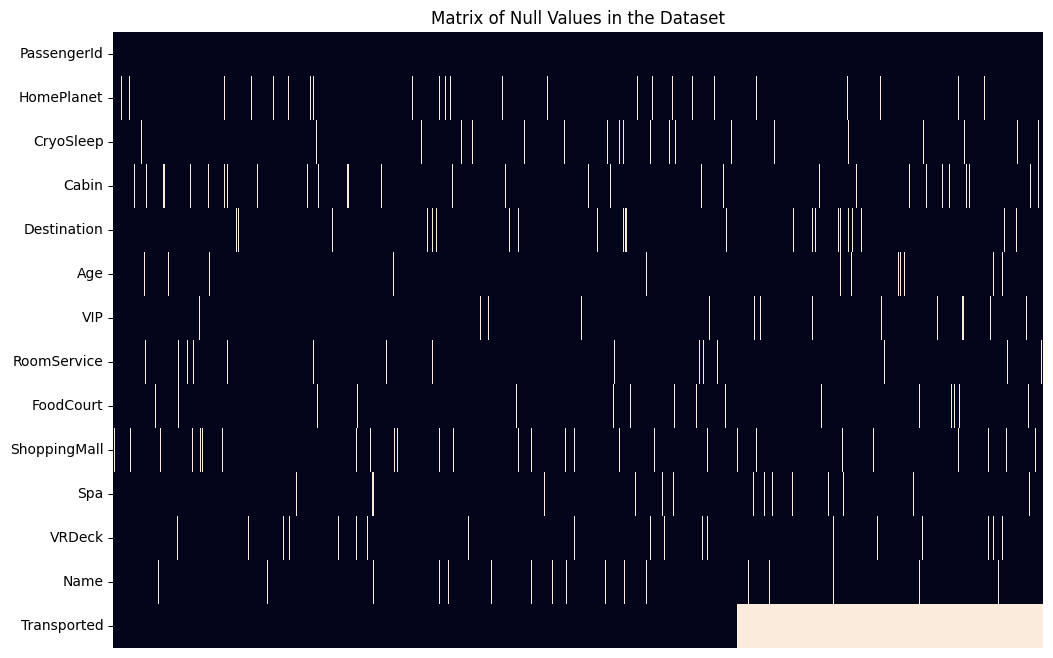

In [233]:
# Display a heatmap of the null values in the dataset to check for patterns
plt.figure(figsize=(12, 8))
sns.heatmap(data.isnull().T, cbar=False,  xticklabels=False)
plt.title("Matrix of Null Values in the Dataset")
plt.show()

In [234]:
rows_with_nulls = data.isnull().any(axis=1).sum()

print(
    f"Number of rows with at least one null value: {rows_with_nulls}. {(rows_with_nulls / data.shape[0] * 100):.2f}% of the dataset."
)

Number of rows with at least one null value: 6364. 49.07% of the dataset.


The missing values are randomly distributed, and the lines affected with a null value are almost half of the dataset, so we cannot remove them.

We will operate now a first part of data manipulation to extract more info from the current features in order to complete our analysis.

At first we can notice that PassengerId retains info about passengers travelling together, so we can assign a `GroupID`, a size of the group and a flag for passengers travelling alone.

In [235]:
data["GroupID"] = data["PassengerId"].apply(lambda x: x.split("_")[0])

group_sizes = data["GroupID"].value_counts()
data["GroupSize"] = data["GroupID"].map(group_sizes).astype(int)

data["IsAlone"] = (data["GroupSize"] == 1).astype(bool)

As we previously said the cabin number contains information on the spaceship deck and side, similarly as we did before we will split into separate features.

In [236]:
data[["Deck", "CabinNum", "Side"]] = data["Cabin"].str.split("/", expand=True)
data["CabinNum"] = pd.to_numeric(data["CabinNum"], errors="coerce")

It might come in handy to have a total of the single passenger expenses, we might later decided to drop the single services.

In [237]:
services = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
data["TotalExpenses"] = data[services].sum(axis=1)

data["IsSpending"] = (data["TotalExpenses"] > 0).astype(bool)

We know that women and children were prioritized for the lifeboats, so we can assume that the survival rate for women and children could be higher than for men in a spaceship as well. Unfortunately, we do not have information on the gender of the passengers, but we can try to use the name of the passengers to infer the gender. At the same time the surname could be useful to ientify families travelling together.

In [238]:
data[["FirstName", "Surname"]] = data["Name"].str.split(" ", expand=True)

In [239]:
groups = data[data["IsAlone"] == False]

### ***Gender***

Let's try to detect gender from the name of the passengers.

In [240]:
gender_detector = gender.Detector()

def detect_gender(first_name):
    if first_name is None:
        return "Unknown"

    gender_guess = gender_detector.get_gender(first_name)
    return gender_guess


data["Gender"] = data["FirstName"].apply(detect_gender)

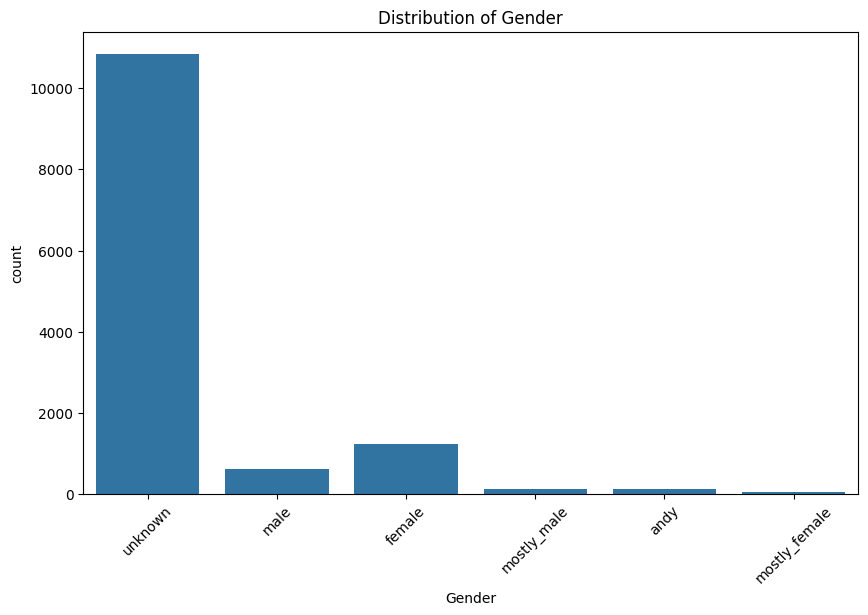

In [241]:
plt.figure(figsize=(10, 6))
sns.countplot(x="Gender", data=data)
plt.title(f"Distribution of Gender")
plt.xticks(rotation=45)
plt.show()

Unfortunately through this method we didn't obtain the desired result. Other more reliable tools to detect gender by name, like Genderize, are not free for such an amount of records. We don't have enough useful information from this library so we will remove the Gender column.

In [242]:
data.drop(["FirstName", "Gender"], axis=1, inplace=True)

We will still keep Surname because it can be useful for imputation.

In [243]:
data.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

  Transported GroupID  GroupSize  IsAlone Deck  CabinNum Side  TotalExpenses  \
0       False    0001          1     True    B       0.0    P            0.0   
1        True    0002          1     True    F       0.0    S          736.0   
2       False    0003          2    False    A       0.0    S        10383.0   
3       False    0003          2    False    A       0.0    S         5176.0   
4        True    0004          1     True    F       1.0    S         1091.0   

   IsSpending      Surname  
0       False    Ofracculy  
1        True        Vines  
2        True       Susent  
3        True       Susent  
4        True  Santantines

### ***Target Variable***

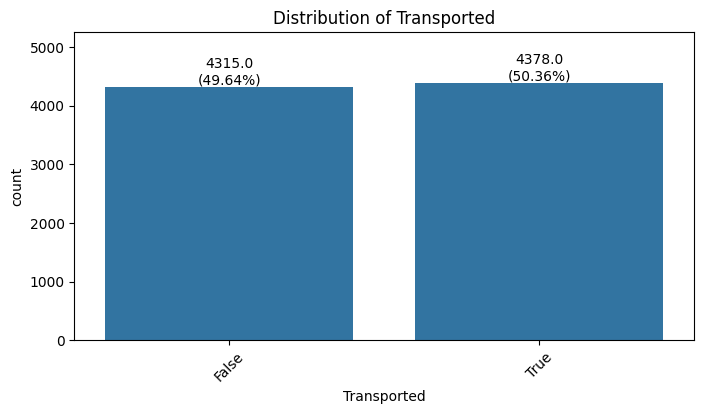

In [244]:
total = len(train_data)  # Total number of samples

plt.figure(figsize=(8, 4))
ax = sns.countplot(x='Transported', data=train_data)
plt.title("Distribution of Transported")

# Loop over the bars to add text
for p in ax.patches:
    count = p.get_height()
    percentage = 100 * count / total
    ax.annotate(f'{count}\n({percentage:.2f}%)', 
                (p.get_x() + p.get_width() / 2., count), 
                ha='center', va='bottom')

# Resize y-axis range to give enough space for the labels
ax.set_ylim(0, max([p.get_height() for p in ax.patches]) * 1.2)

plt.xticks(rotation=45)
plt.show()

The dataset seems to bee balanced, this is a good news for us.

### ***Distribution of the features***

We are going to display the distribution of the features in the dataset, to find useful insights.

In [245]:
numerical_features = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "TotalExpenses",
    "CabinNum",
    "GroupSize",
]
binary_features = ["CryoSleep", "VIP", "IsAlone", "IsSpending"]
categorical_features = ["HomePlanet", "Destination", "Deck", "Side"]

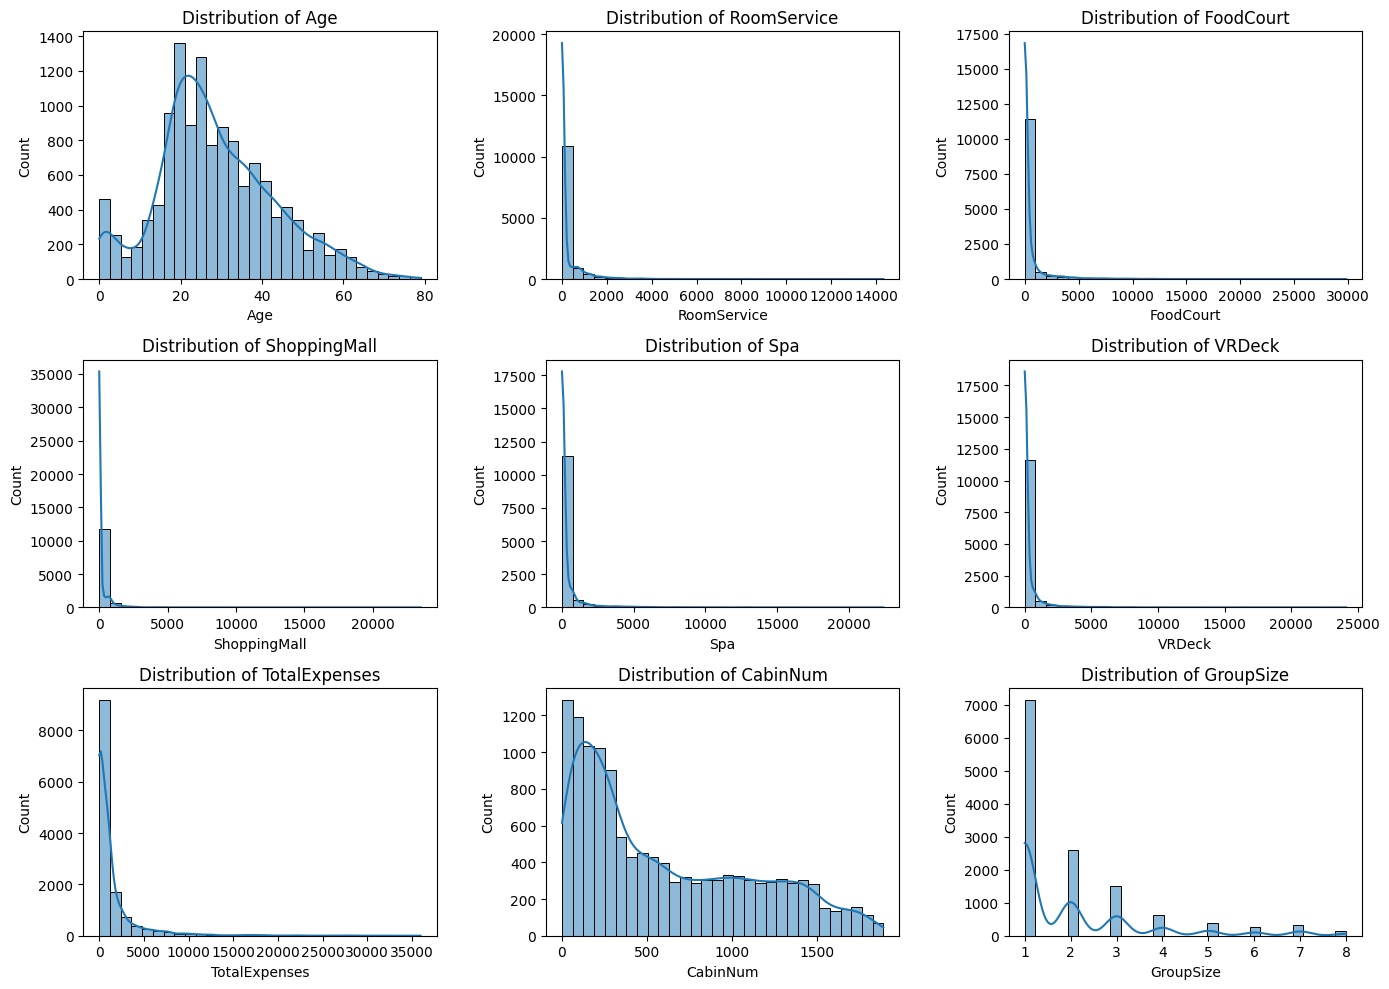

In [246]:
# Plot the distribution of numerical features
plt.figure(figsize=(14, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(data[feature].dropna(), kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

As previously mentione, we were expecting a very skewed distribution for expenses features, we see a really long right tail. The largest part of the passengers is in the range from 20 to 30 years old, infants seem to be more than children.

Let's check categorical and boolean values

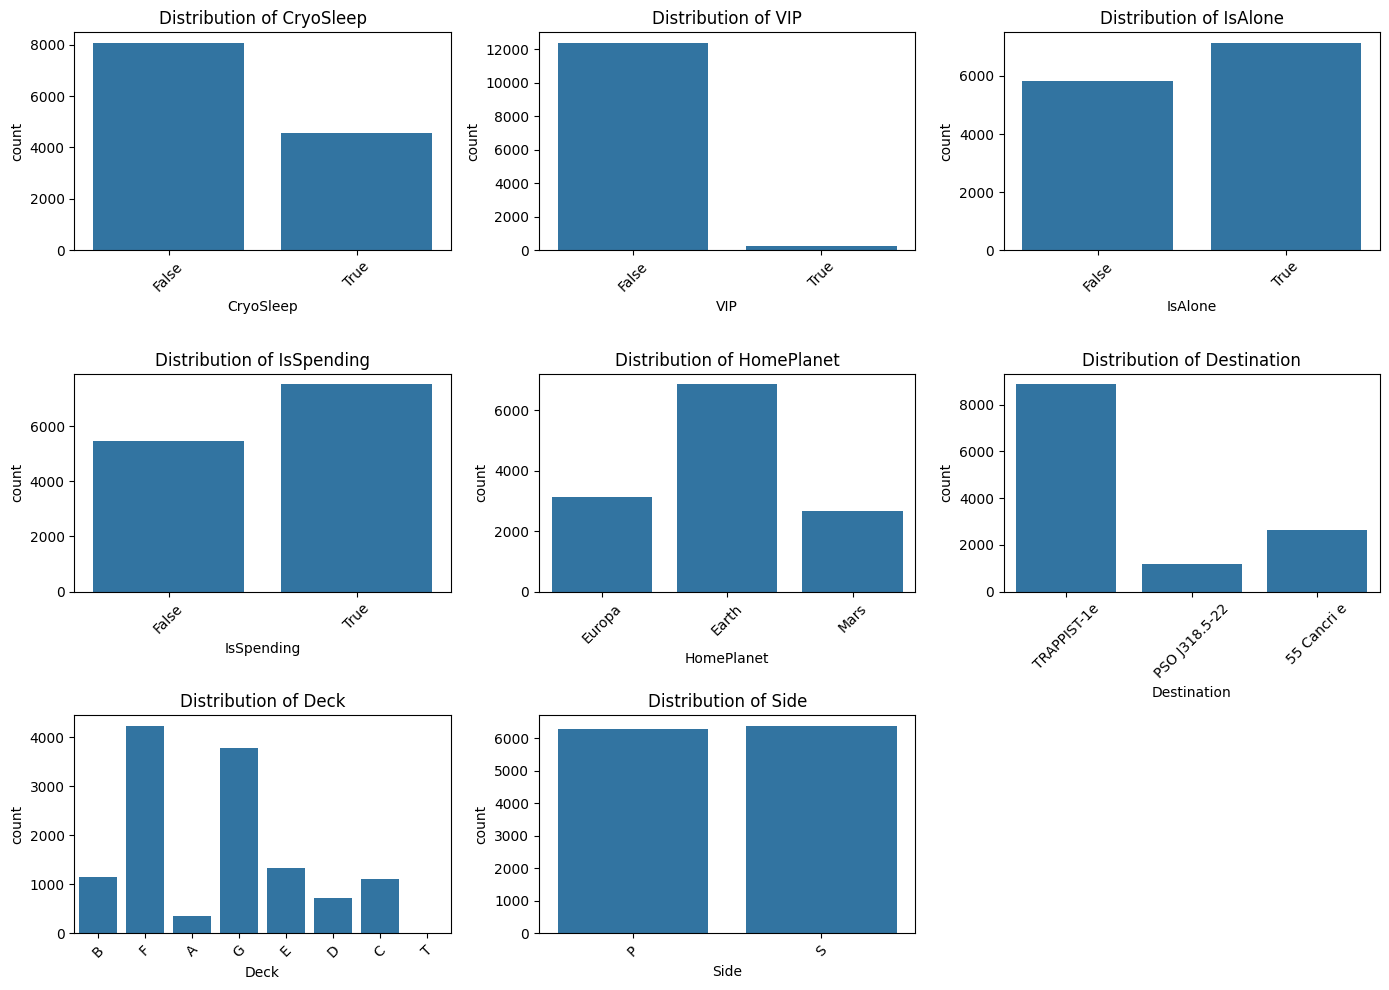

In [247]:
data = data.reset_index(drop=True)

plt.figure(figsize=(14, 10))
for i, feature in enumerate(binary_features + categorical_features):
    plt.subplot(3, 3, i + 1)
    sns.countplot(x=feature, data=data)
    plt.title(f"Distribution of {feature}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The `VIP` status is very uncommon, about one third of the passengers are in `cryosleep` status, they might be facing a very long journey. Most of the passengers are travelling alone, but, even if the median of expenses is 0, most of the passengers are spenders. `Homeplanet` and `Destinatio`n are very imbalanced, as it is the `Deck` distribution, suggesting a shape of the spaceship irregular, but with a simmetri between the two sides.

### ***Bivariate Analysis***

Let's evaluate the features towards the target variable

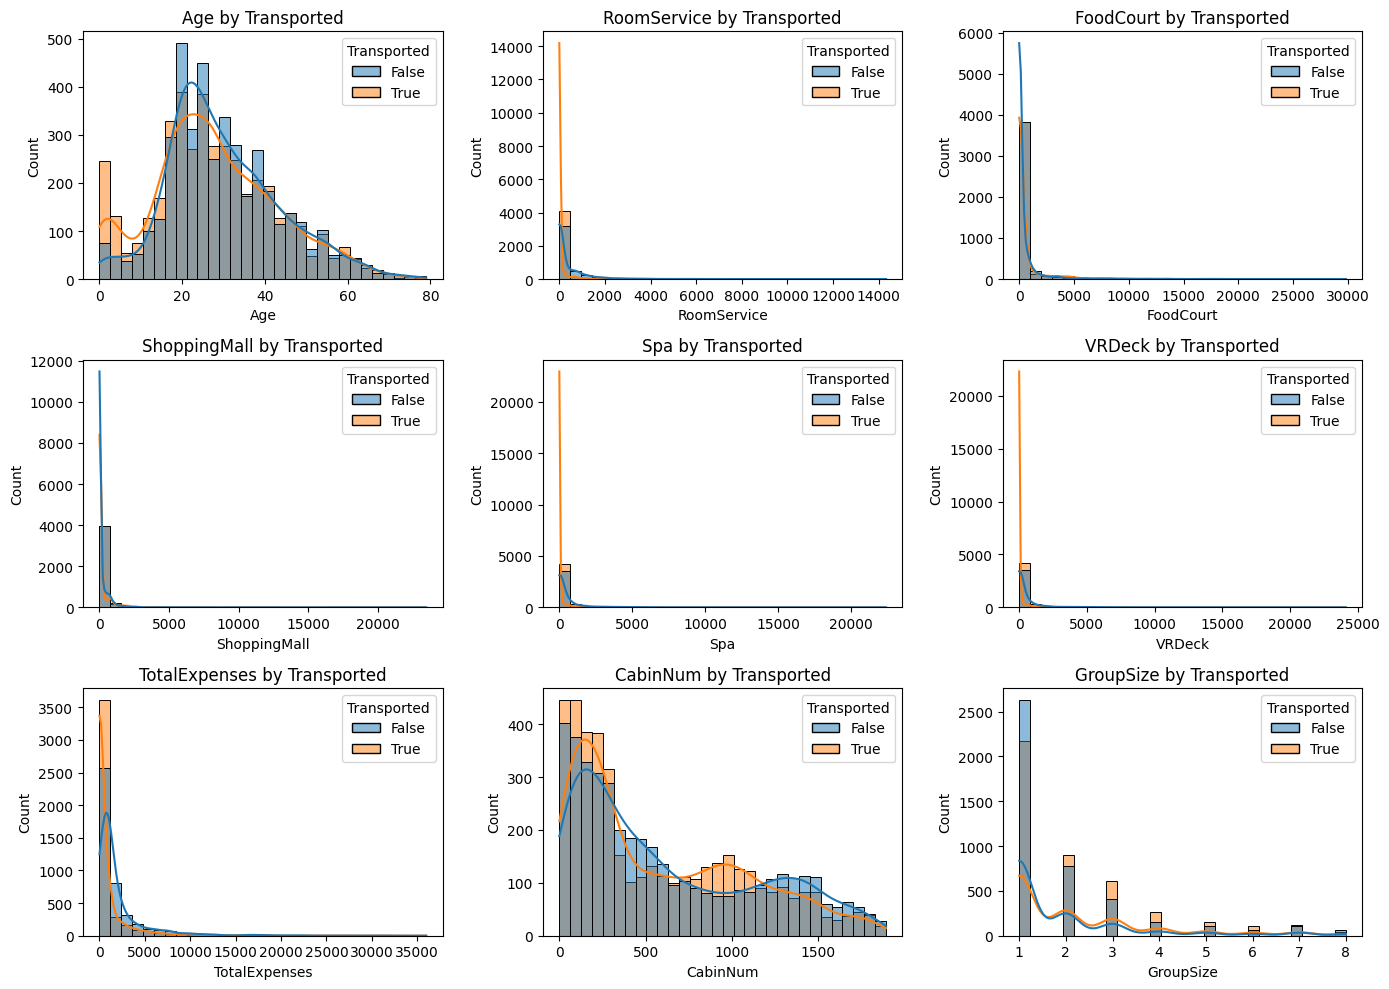

In [248]:
plt.figure(figsize=(14, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(data=data, x=feature, hue="Transported", kde=True, bins=30)
    plt.title(f"{feature} by Transported")
plt.tight_layout()
plt.show()

For the expenses features the view is not extremely clear but we can spot `FoodCourt` and `ShoppingMall` in opposite trend compared to `RoomService`, `Spa` and `VRDeck`.
We see that up to 18 years old the probabilities of being transported are higher and we see and interesting crossing at regulare intervals for the cabin number. 

### ***Hypothesis Testing***

In the context of our analysis, we will be conducting hypothesis tests to evaluate the differences in passenger survival rates based on cabin numbers. The hypotheses are defined as follows:

**Null Hypothesis (H0)**: There is no significant difference in the survival rates of passengers based on their cabin numbers split by given thresholds. In other words, the mean survival rates for the different cabin number groups are equal.

**Alternative Hypothesis (H1)**: There is a significant difference in the survival rates of passengers based on their cabin numbers. This implies that at least one group has a different mean survival rate compared to the others.

We will use a significance level (α) of 0.05 for our tests. If the p-value obtained from the t-test is less than α, we will reject the null hypothesis in favor of the alternative hypothesis.

In [249]:
train_data.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

In [250]:
thresholds = [300, 600, 1200]
train_data = data[~data["Transported"].isnull()]
not_null_cabins = train_data["CabinNum"].notna()

below_300 = train_data[(not_null_cabins) & (train_data["CabinNum"] < 300)][
    "Transported"
].astype(int)
between_300_600 = train_data[
    (not_null_cabins) & (train_data["CabinNum"] >= 300) & (train_data["CabinNum"] < 600)
]["Transported"].astype(int)
between_600_1200 = train_data[
    (not_null_cabins)
    & (train_data["CabinNum"] >= 600)
    & (train_data["CabinNum"] < 1200)
]["Transported"].astype(int)
above_1200 = train_data[not_null_cabins & (train_data["CabinNum"] >= 1200)][
    "Transported"
].astype(int)


def perform_ttest(group1, group2, alpha=0.05):
    t_stat, p_value = ttest_ind(group1, group2, equal_var=False, nan_policy="omit")

    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    n1, n2 = len(group1), len(group2)

    se = np.sqrt(std1**2 / n1 + std2**2 / n2)

    ci_lower = (mean1 - mean2) - 1.96 * se
    ci_upper = (mean1 - mean2) + 1.96 * se

    reject_null = p_value < alpha

    return t_stat, p_value, (ci_lower, ci_upper), reject_null

results_below_300_300_600 = perform_ttest(below_300, between_300_600)
results_300_600_600_1200 = perform_ttest(between_300_600, between_600_1200)
results_600_1200_above_1200 = perform_ttest(between_600_1200, above_1200)

def print_results(test_name, results):
    t_stat, p_value, ci, reject_null = results
    print(f"{test_name}:")
    print(f"  T-Test Statistic: {t_stat:.4f}")
    print(f"  P-Value: {p_value:.2e}")
    print(f"  Confidence Interval: {ci}")
    print(f"  Reject Null Hypothesis: {'Yes' if reject_null else 'No'}\n")

print_results("T-Test: Below 300 vs 300-600", results_below_300_300_600)
print_results("T-Test: 300-600 vs 600-1200", results_300_600_600_1200)
print_results("T-Test: 600-1200 vs Above 1200", results_600_1200_above_1200)

T-Test: Below 300 vs 300-600:
  T-Test Statistic: 8.2748
  P-Value: 1.96e-16
  Confidence Interval: (0.0963381000673019, 0.15614166313192493)
  Reject Null Hypothesis: Yes

T-Test: 300-600 vs 600-1200:
  T-Test Statistic: -9.6029
  P-Value: 1.51e-21
  Confidence Interval: (-0.19594721629216663, -0.12951829642747667)
  Reject Null Hypothesis: Yes

T-Test: 600-1200 vs Above 1200:
  T-Test Statistic: 9.2098
  P-Value: 5.77e-20
  Confidence Interval: (0.12324338202239457, 0.18988163860534893)
  Reject Null Hypothesis: Yes



It seems the groups have indeed a different mean survival rate compared to the others. We will explore this further in the next section.

### ***Hypothesis Testing: Impact of Age on Transported Status***

In this analysis, we will test whether there is a significant difference in the survival rates (Transported status) of passengers based on whether they are above or below the age of 18. 

- **Null Hypothesis (H0)**: There is no significant difference in the survival rates of passengers aged 18 and below compared to those above 18. (Mean survival rates are equal.)
  
- **Alternative Hypothesis (H1)**: There is a significant difference in the survival rates of passengers aged 18 and below compared to those above 18. (Mean survival rates are not equal.)

In [251]:
age_threshold = 18

below_18 = train_data[train_data['Age'] <= age_threshold]['Transported'].astype(int)
above_18 = train_data[train_data['Age'] > age_threshold]['Transported'].astype(int)

t_stat, p_value = ttest_ind(below_18, above_18, equal_var=False, nan_policy='omit')

print(f"T-Test Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4e}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis (H0): There is a significant difference in survival rates.")
else:
    print("Fail to reject the null hypothesis (H0): There is no significant difference in survival rates.")

T-Test Statistic: 10.3406
P-Value: 1.1757e-24
Reject the null hypothesis (H0): There is a significant difference in survival rates.


Let's see now the distribution of categorical features towards target variable.

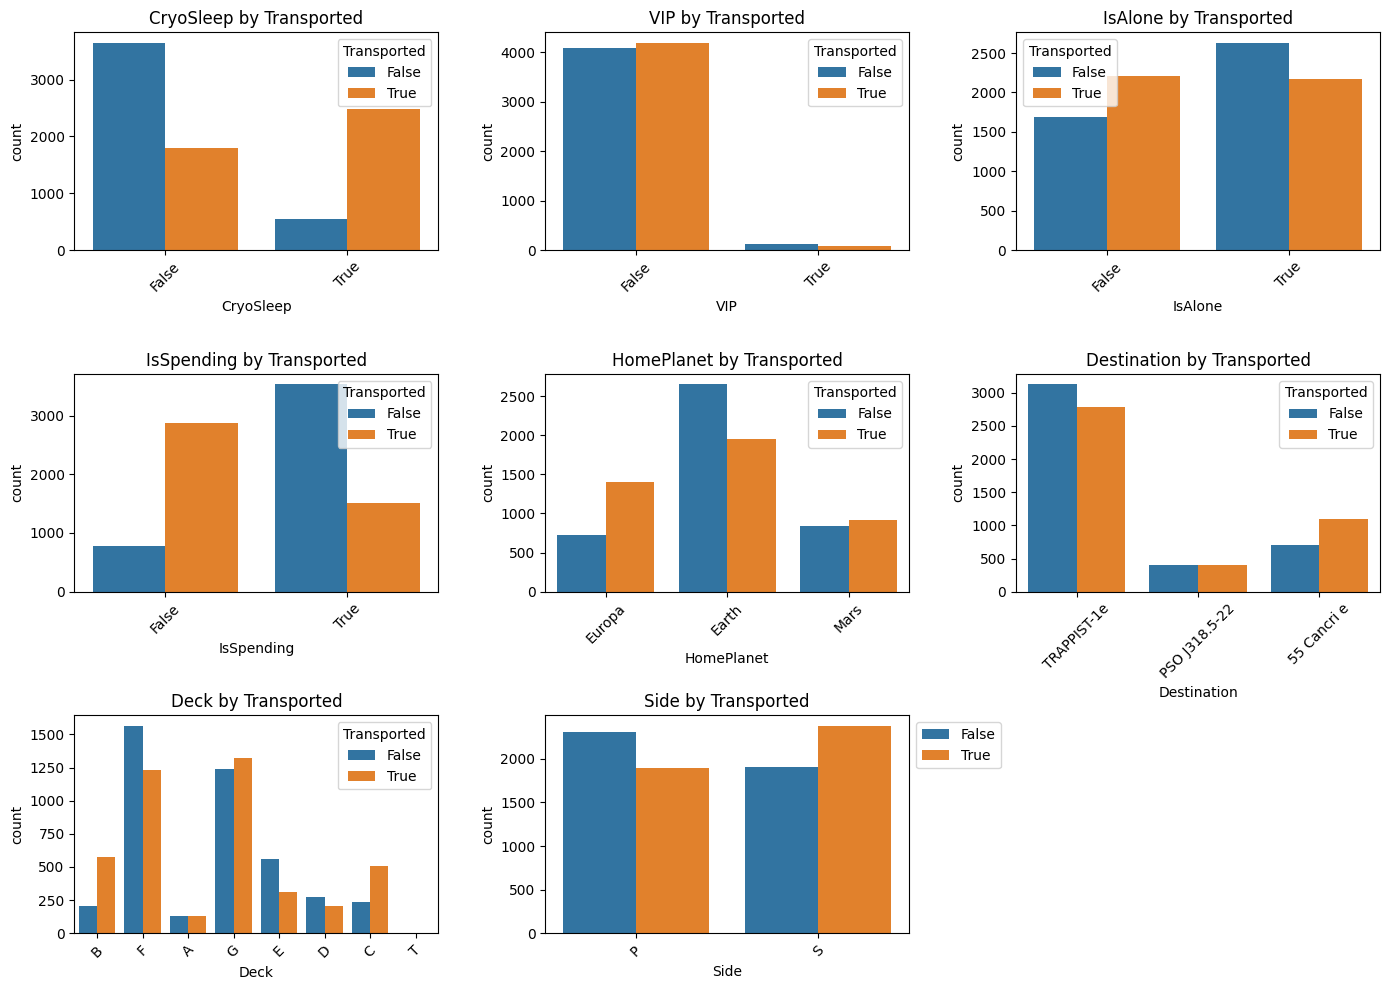

In [252]:
filtered_data = data.dropna(subset=["Transported"])

plt.figure(figsize=(14, 10))
for i, feature in enumerate(binary_features + categorical_features):
    plt.subplot(3, 3, i + 1)
    ax = sns.countplot(x=feature, hue="Transported", data=filtered_data)

    if feature == "Side":
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

    plt.title(f"{feature} by Transported")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

With the exception of `VIP` feature we assist to a different distribution of the target variable throughout all the categorical features.

## ***Data Imputation***

We will impute only missing values that will not cause data leakage, if there will be additional missing values after this process we will create an imputation pipeline.


### ***HomePlanet***
Let's start from HomePlanet, it is logical to think that passengers travelling in the same group have left from the same planet.

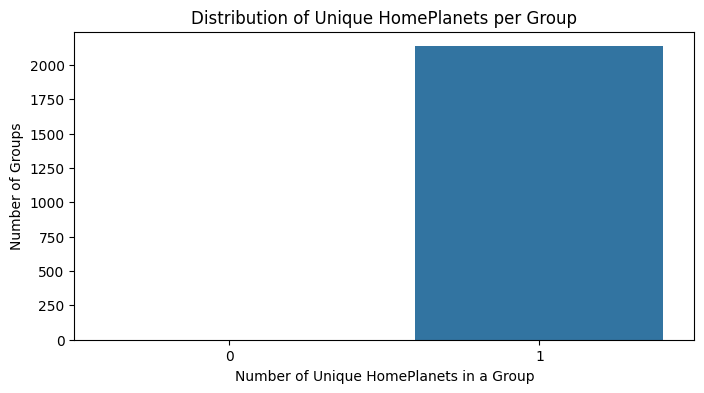

In [253]:
group_homeplanet_consistency = groups.groupby("GroupID")["HomePlanet"].nunique()

plt.figure(figsize=(8, 4))
sns.countplot(x=group_homeplanet_consistency, data=data)
plt.title("Distribution of Unique HomePlanets per Group")
plt.xlabel("Number of Unique HomePlanets in a Group")
plt.ylabel("Number of Groups")
plt.show()

We can see that, with the exclusion of missing values, all groups of passengers are from the same HomePlanet, so we can safely impute it based on group ID.

In [254]:
missing_homeplanet = data["HomePlanet"].isnull()

group_homeplanet = groups.groupby("GroupID")["HomePlanet"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
)

data.loc[missing_homeplanet, "HomePlanet"] = data.loc[
    missing_homeplanet, "GroupID"
].map(group_homeplanet)

null_values = data[["HomePlanet"]].isnull().sum()
null_values

HomePlanet    157
dtype: int64

Let's now visualize the distribution of `HomePlanet` by `Deck`

<Axes: xlabel='Deck', ylabel='HomePlanet'>

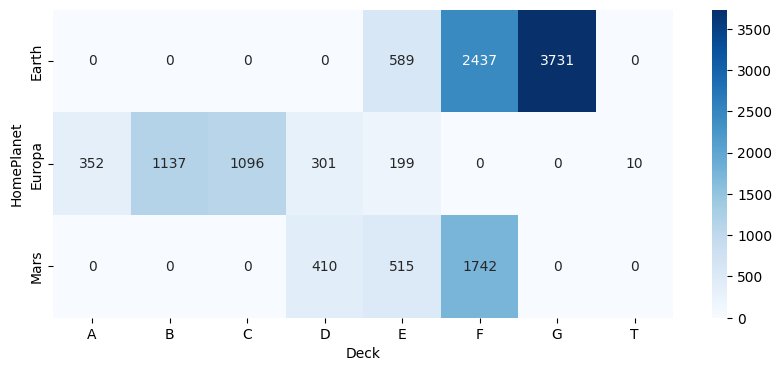

In [255]:
deck_homeplanet = (
    data.groupby(["Deck", "HomePlanet"])["HomePlanet"].size().unstack().fillna(0)
)

# Heatmap of missing values
plt.figure(figsize=(10, 4))
sns.heatmap(deck_homeplanet.T, annot=True, fmt="g", cmap="Blues")

We notice that passengers travelling in decks A, B, C or T came from Europa, while in deck G they are from Earth.

In [256]:
data.loc[
    (data["HomePlanet"].isna()) & (data["Deck"].isin(["A", "B", "C", "T"])),
    "HomePlanet",
] = "Europa"

data.loc[(data["HomePlanet"].isna()) & (data["Deck"] == "G"), "HomePlanet"] = "Earth"

data[["HomePlanet"]].isna().sum()

HomePlanet    94
dtype: int64

Now let's focus on families, it might be reasonable to find some consistency in origin by surname.

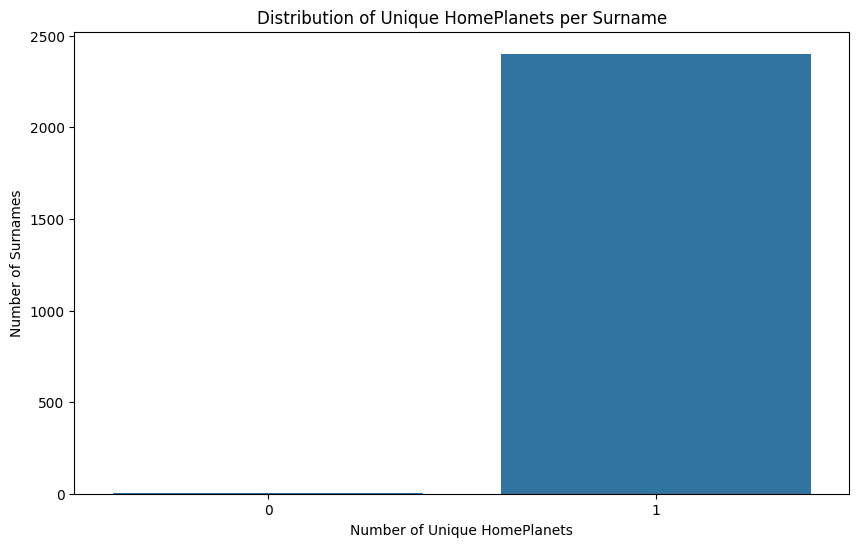

In [257]:
unique_planets_per_surname = data.groupby("Surname")["HomePlanet"].nunique()

plt.figure(figsize=(10, 6))
sns.countplot(x=unique_planets_per_surname)
plt.title("Distribution of Unique HomePlanets per Surname")
plt.xlabel("Number of Unique HomePlanets")
plt.ylabel("Number of Surnames")
plt.show()

Again, with the exception of missing values we have a unique HomePlanet for passengers having the same surname.

In [258]:
surname_to_homeplanet = data.groupby("Surname")["HomePlanet"].agg(
    lambda x: x.mode()[0] if not x.mode().empty else None
)

def impute_homeplanet(row):
    if pd.isnull(row["HomePlanet"]) and row["Surname"] in surname_to_homeplanet:
        return surname_to_homeplanet[row["Surname"]]
    else:
        return row["HomePlanet"]

data["HomePlanet"] = data.apply(impute_homeplanet, axis=1)

data[["HomePlanet"]].isna().sum()

HomePlanet    10
dtype: int64

We are left with only 10 passengers, let's see if we can spot any similarities between them.

In [259]:
data[data["HomePlanet"].isna()].head(10)

PassengerId HomePlanet CryoSleep     Cabin  Destination   Age    VIP  \
2274      2443_01        NaN     False    D/72/P  TRAPPIST-1e  31.0  False   
2631      2817_01       None     False   F/584/P  TRAPPIST-1e  25.0  False   
3091      3331_01        NaN     False   F/631/S  TRAPPIST-1e  40.0  False   
4548      4840_01        NaN      True   F/915/S  TRAPPIST-1e  36.0  False   
5762      6108_01        NaN     False  F/1166/S  TRAPPIST-1e  13.0  False   
8969      0616_01       None     False    E/40/S  TRAPPIST-1e  31.0  False   
10583     4052_01       None     False   D/136/P  TRAPPIST-1e  26.0  False   
11913     7065_01       None      True   E/471/S  TRAPPIST-1e  28.0  False   
12551     8435_01        NaN       NaN  F/1730/P  TRAPPIST-1e  19.0  False   
12725     8775_01       None      True   D/275/P  TRAPPIST-1e  40.0  False   

       RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
2274        1458.0      421.0          76.0     0.0     0.0   
2631         237.0        0.0         910.0     0.0    12.0   
3091         666.0        4.0          83.0     0.0    50.0   
4548           0.0        0.0           NaN     0.0     0.0   
5762         206.0       28.0           0.0     1.0   629.0   
8969           0.0      428.0           NaN  1154.0  1025.0   
10583          6.0     5903.0           0.0   240.0    72.0   
11913          0.0        0.0           0.0     0.0     NaN   
12551        162.0       11.0           0.0     0.0  1216.0   
12725          0.0        0.0           0.0     0.0     0.0   

                     Name Transported GroupID  GroupSize  IsAlone Deck  \
2274                  NaN       False    2443          1     True    D   
2631         Sealfs Sutty       False    2817          1     True    F   
3091                  NaN        True    3331          1     True    F   
4548                  NaN        True    4840          1     True    F   
5762                  NaN       False    6108          1     True    F   
8969      Arkaban Spriney         NaN    0616          1     True    E   
10583  Ankabih Coneveseng         NaN    4052          1     True    D   
11913   Zedares Maltorted         NaN    7065          1     True    E   
12551                 NaN         NaN    8435          1     True    F   
12725    Raston Maltorted         NaN    8775          1     True    D   

       CabinNum Side  TotalExpenses  IsSpending     Surname  
2274       72.0    P         1955.0        True         NaN  
2631      584.0    P         1159.0        True       Sutty  
3091      631.0    S          803.0        True         NaN  
4548      915.0    S            0.0       False         NaN  
5762     1166.0    S          864.0        True         NaN  
8969       40.0    S         2607.0        True     Spriney  
10583     136.0    P         6221.0        True  Coneveseng  
11913     471.0    S            0.0       False   Maltorted  
12551    1730.0    P         1389.0        True         NaN  
12725     275.0    P            0.0       False   Maltorted

It looks they have some common traits:
- Destination - they are all heading to TRAPPIST-1e
- VIP status - none of them is VIP
- Decks - they have cabins in D, E or F
- IsAlone - obviously all of them are travelling alone since we have already imputed group travellers

Of all these traits the most useful could be Destinatiion and Decks.

<Figure size 1000x400 with 0 Axes>

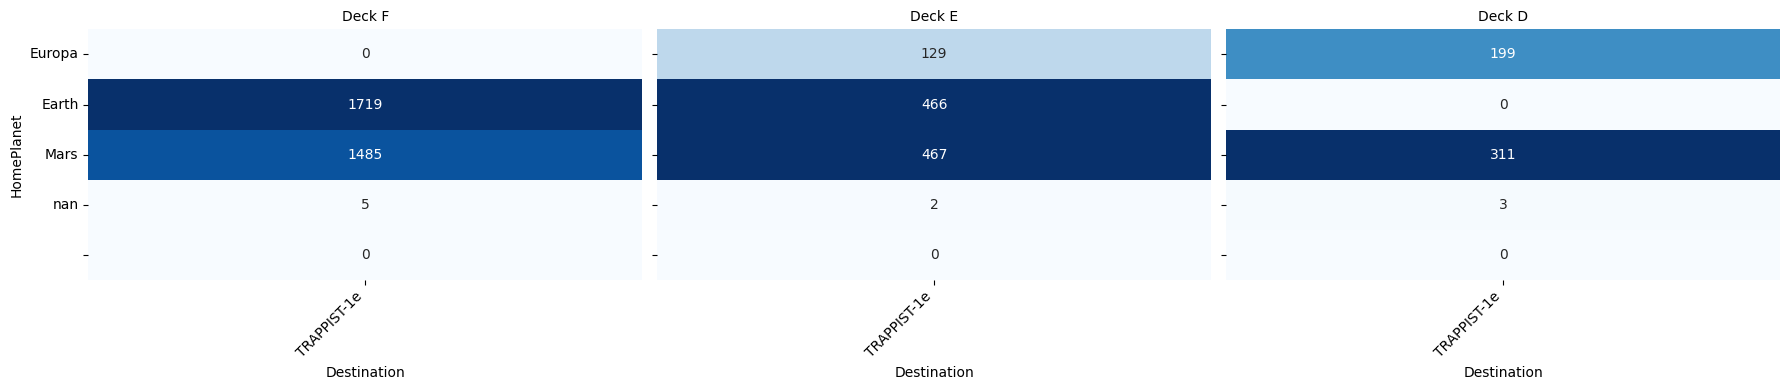

In [260]:
filtered_data = data[
    (data["Deck"].isin(["D", "E", "F"])) & (data["Destination"] == "TRAPPIST-1e")
]

all_homeplanets = data["HomePlanet"].unique()
all_destinations = ["TRAPPIST-1e"]

def facet_heatmap(data, **kwargs):
    crosstab_data = pd.crosstab(
        data["HomePlanet"], data["Destination"], dropna=False
    ).reindex(index=all_homeplanets, columns=all_destinations, fill_value=0)
    sns.heatmap(crosstab_data, cmap="Blues", annot=True, fmt="d", cbar=False, **kwargs)


plt.figure(figsize=(10, 4))

g = sns.FacetGrid(filtered_data, col="Deck", col_wrap=3, height=4, aspect=1.5)
g.map_dataframe(facet_heatmap)

g.set_titles(col_template="Deck {col_name}")
for ax in g.axes.flatten():
    ax.set_xlabel("Destination", fontsize=10)
    ax.set_ylabel("HomePlanet", fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    ax.set_yticks([i + 0.5 for i in range(len(all_homeplanets))])
    ax.set_yticklabels(
        all_homeplanets, rotation=0, ha="right"
    )

plt.tight_layout()
plt.show()

Since the missing values are only 10 we can impute according to facet heatmap.

In [261]:
data.loc[(data["HomePlanet"].isna()) & ~(data["Deck"] == "F"), "HomePlanet"] = "Mars"
data.loc[(data["HomePlanet"].isna()) & (data["Deck"] == "F"), "HomePlanet"] = "Earth"

data[["HomePlanet"]].isna().sum()

HomePlanet    0
dtype: int64

We have complete the first imputation, let's now move to expenses for services.

### ***Expenses***

Having a look at the database it looks like youngest passengers are not spending money, let's verify that. If confirmed we can impute the missing values with 0.

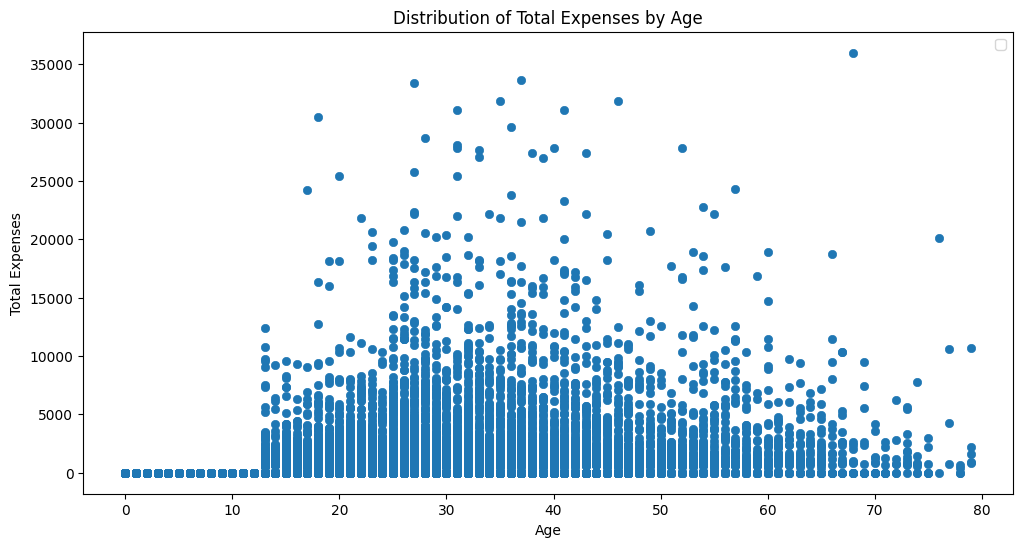

In [262]:
data = data.reset_index(drop=True)

plt.figure(figsize=(12, 6))
sns.scatterplot(x="Age", y="TotalExpenses", data=data, edgecolor=None)
plt.title("Distribution of Total Expenses by Age")
plt.xlabel("Age")
plt.ylabel("Total Expenses")
plt.legend()
plt.show()

In [263]:
data.loc[data["Age"] < 13, services] = 0

under_13_expenses = data.loc[data["Age"] < 13, services].sum().sum()
under_13_expenses

0.0

In [264]:
data[services].isna().sum()

RoomService     235
FoodCourt       269
ShoppingMall    280
Spa             262
VRDeck          233
dtype: int64

It is logical to think that the passengers in CryoSleep status are not having any expenses.

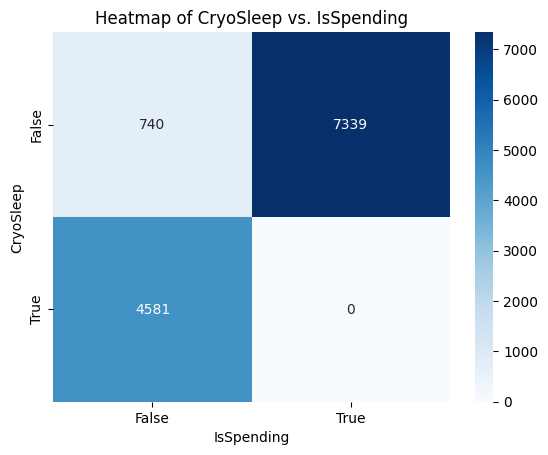

In [265]:
cryospending_data = pd.crosstab(data["CryoSleep"], data["IsSpending"])

sns.heatmap(cryospending_data, annot=True, fmt="d", cmap="Blues")
plt.title("Heatmap of CryoSleep vs. IsSpending")
plt.show()

As we can see all passengers in `CryoSleep` status are not spending, unfortunately a large part of awake people are non spenders, we cannot easily impute the value.

In [266]:
data.loc[data["CryoSleep"] == True, services] = 0

cryo_expenses_sum = data.loc[data["CryoSleep"] == True, services].sum().sum()
cryo_expenses_sum

0.0

In [267]:
data[services].isna().sum()

RoomService     162
FoodCourt       171
ShoppingMall    163
Spa             166
VRDeck          150
dtype: int64

### ***CryoSleep***

Let's see if Cryosleep status has some age threshold as well.


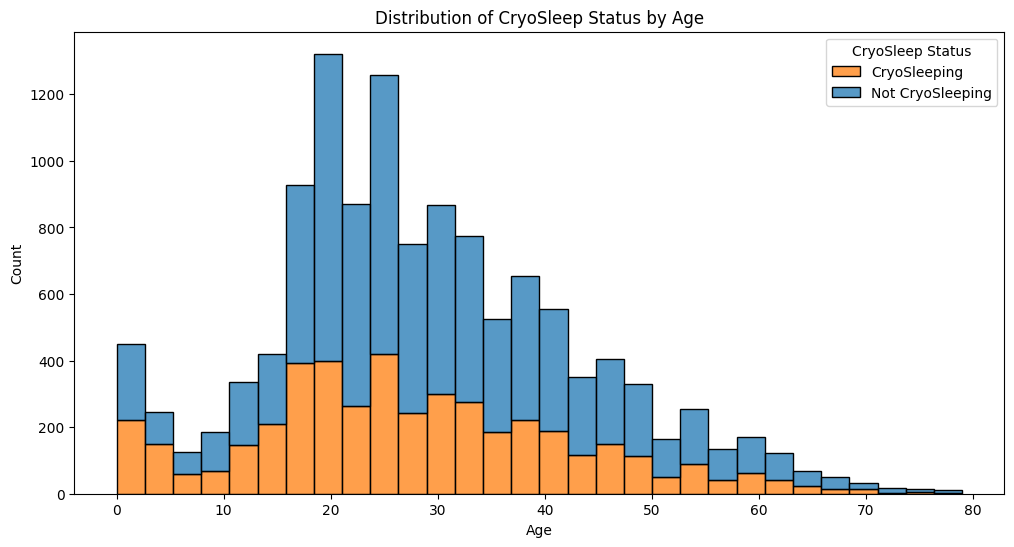

In [268]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x="Age", hue="CryoSleep", multiple="stack", bins=30)
plt.title("Distribution of CryoSleep Status by Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend(title="CryoSleep Status", labels=["CryoSleeping", "Not CryoSleeping"])
plt.show()

There is no useful info from distribution by age. But we can surely impute False value to people who are spending.

In [269]:
impute_expense_condition = (data["CryoSleep"].isnull()) & (data["IsSpending"] == True)
data.loc[impute_expense_condition, "CryoSleep"] = False

What if we look at the `CryoSleep` status of passengers in the same cabin together with expenses? It might be reasonable that people in `CryoSleep` are travelling together and therefore not spending anything.

In [270]:
cabin_cryosleep_status = (
    data.groupby("Cabin")
    .agg(
        {
            "CryoSleep": lambda x: x.mode()[0] if not x.mode().empty else np.nan,
            "TotalExpenses": "mean",
        }
    )
    .reset_index()
)

data_merged = pd.merge(
    data, cabin_cryosleep_status, on="Cabin", suffixes=("", "_Cabin")
)

data_merged["CryoSleep_Cabin"] = data_merged["CryoSleep_Cabin"].astype(bool)

condition = (data_merged["CryoSleep_Cabin"] == True) & (
    data_merged["TotalExpenses_Cabin"] == 0
)

likelihood_cryosleep = data_merged.loc[condition, "CryoSleep"].mean()
likelihood_cryosleep

0.9790528233151184

We have a quite good predictor for cryosleep imputation. There are some exeptions to this rule, but it is an acceptable error.
We will cross cabins with people sleeping, cabins with zero expenses and impute `CryoSleep` true if there is any null value.

In [271]:
cabin_cryosleep_status = data.groupby("Cabin")["CryoSleep"].transform(
    "max"
)
cabin_spending_status = data.groupby("Cabin")["IsSpending"].transform("max")

impute_cabin_condition = (
    (data["CryoSleep"].isnull())
    & (cabin_cryosleep_status == True)
    & (cabin_spending_status == False)
)
data.loc[impute_cabin_condition, "CryoSleep"] = True

data[['CryoSleep']].isnull().sum()

CryoSleep    107
dtype: int64

Let's see what is the percentage of lone passengers with zero expenses that are in `CryoSleep`

In [272]:
lone_non_spenders = (data["GroupSize"] == 1) & (data["TotalExpenses"] == 0)

percentage = data.loc[lone_non_spenders, "CryoSleep"].mean()
percentage

0.9447490510333193

Again, not perfect, but a large rate. We can impute `CryoSleep` condition for the lone passengers without expenses

In [273]:
impute_lone_condition = (
    (data["GroupSize"] == 1)
    & (data["TotalExpenses"] == 0)
    & (data["CryoSleep"].isnull())
)
data.loc[impute_lone_condition, "CryoSleep"] = True

In [274]:
data[["CryoSleep"]].isnull().sum()

CryoSleep    55
dtype: int64

Is the position of the cabin relevant? Maybe some decks or a specific side is equipped with special cabins for the CryoSleep passengers?

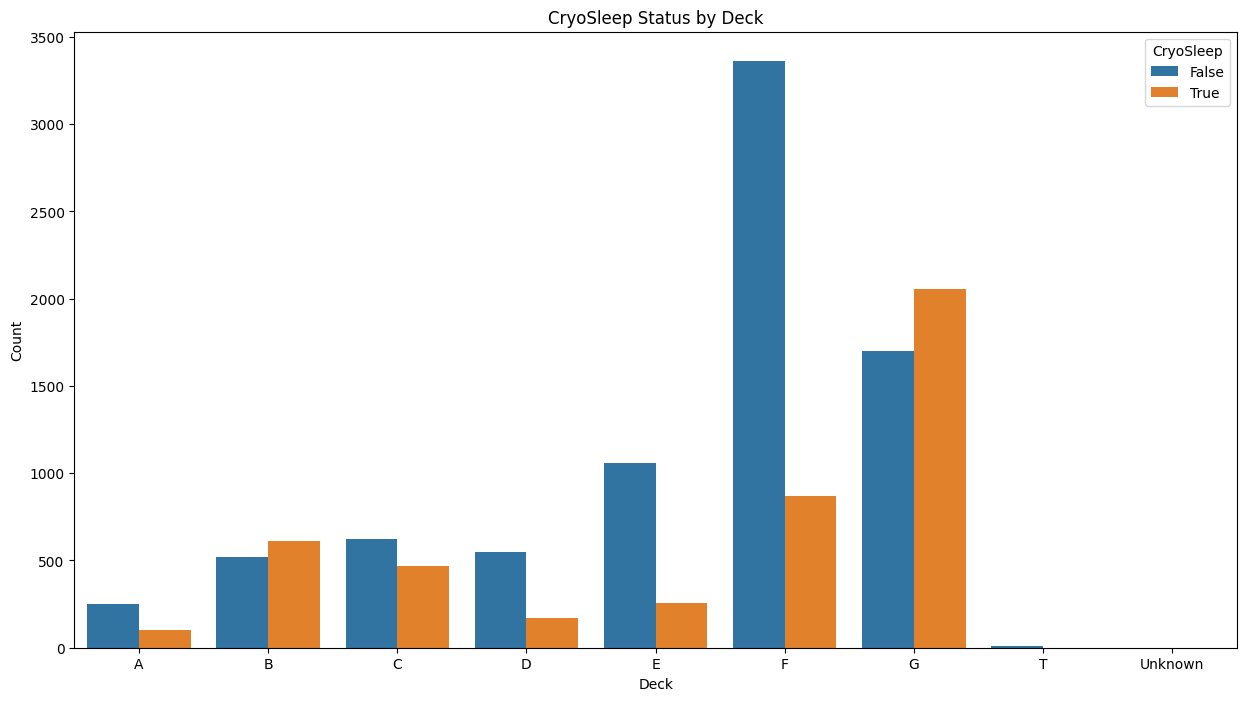

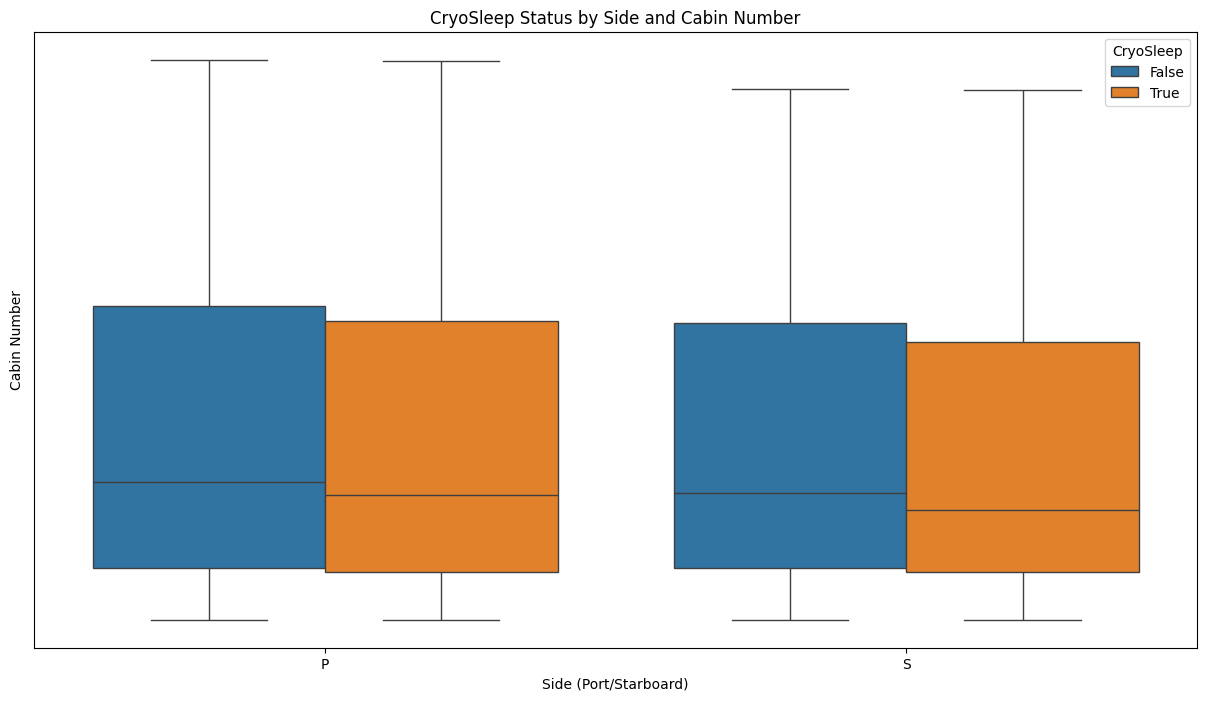

In [275]:
plt.figure(figsize=(15, 8))
sns.countplot(
    x="Deck", hue="CryoSleep", data=data, order=sorted(data["Deck"].fillna("Unknown").astype(str).unique())
)
plt.title("CryoSleep Status by Deck")
plt.xlabel("Deck")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(15, 8))
ax = sns.boxplot(x="Side", y="CabinNum", hue="CryoSleep", data=data)
ax.set_yticklabels([])
ax.tick_params(axis="y", which="both", length=0)
plt.title("CryoSleep Status by Side and Cabin Number")
plt.xlabel("Side (Port/Starboard)")
plt.ylabel("Cabin Number")
plt.show()

The largest part of passengers in cryosleep are in deck G, there is no noticeable difference in cabin number or side though.
It seems there are no passengers in cryosleep in deck T, that might be not for passengers.

In [276]:
cryosleep_deck_T = data[(data["Deck"] == "T") & (data["CryoSleep"] == True)].shape[0]
cryosleep_deck_T

0

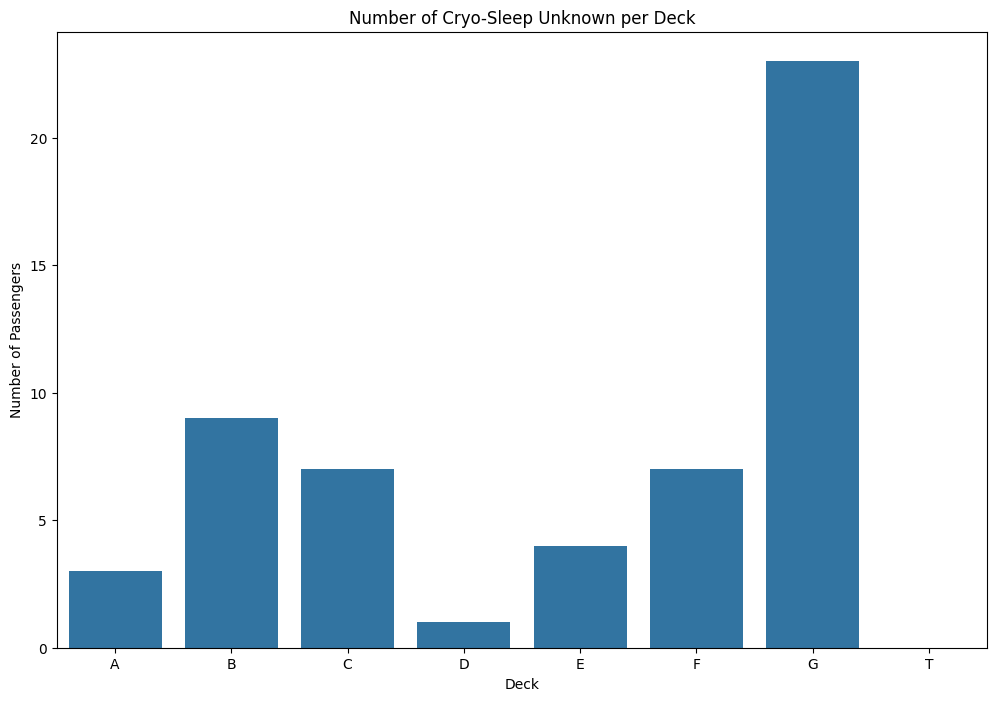

In [277]:
valid_decks = sorted(data["Deck"].dropna().unique())

plt.figure(figsize=(12, 8))
sns.countplot(x="Deck", data=data[data["CryoSleep"].isnull()], order=valid_decks)
plt.title("Number of Cryo-Sleep Unknown per Deck")
plt.xlabel("Deck")
plt.ylabel("Number of Passengers")
plt.show()

We don't have solid info to make an imputation at this stage, we will impute the remaining after split.

### ***VIP Status***

We have seen that the quota of `VIP` passengers is really small, let's try to find common traits between them.

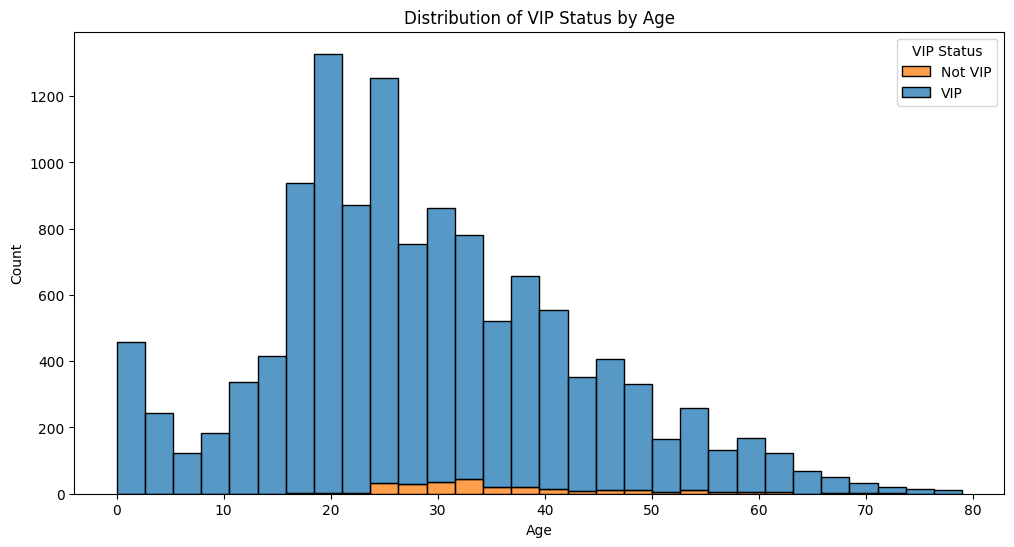

In [278]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x="Age", hue="VIP", multiple="stack", bins=30)
plt.title("Distribution of VIP Status by Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend(title="VIP Status", labels=["Not VIP", "VIP"])
plt.show()

It seems younger passengers are not in `VIP` category.

In [279]:
vip_passengers = data[data["VIP"] == True]
vip_passengers["Age"].min().astype(int)

18

Let's impute False for passengers under 18.

In [280]:
data.loc[data["Age"] < 18, "VIP"] = False

under_18_vip_count = data.loc[(data["Age"] < 18) & (data["VIP"] == True)].shape[0]
under_18_vip_count

0

In [281]:
data[['VIP']].isnull().sum()

VIP    242
dtype: int64

Can passengers in `CryoSleep` status be `VIP`?

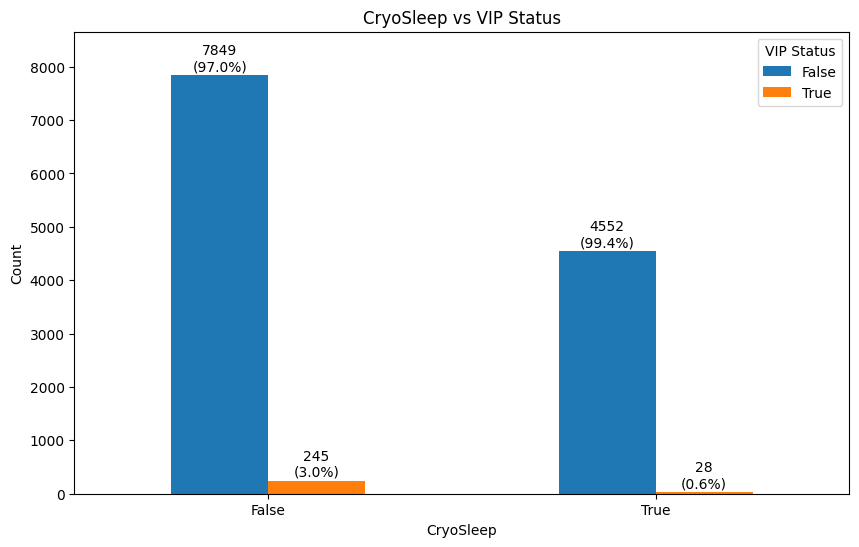

In [282]:
cryo_vip_crosstab = pd.crosstab(data["CryoSleep"], data["VIP"])

ax = cryo_vip_crosstab.plot(kind="bar", stacked=False, figsize=(10, 6))

for p in ax.patches:
    height = p.get_height()

    cryosleep_category = p.get_x() + p.get_width() / 2.0
    cryosleep_category = int(round(cryosleep_category))

    total_for_cryosleep = cryo_vip_crosstab.iloc[cryosleep_category].sum()

    percentage = (
        f"{100 * height / total_for_cryosleep:.1f}%"
        if total_for_cryosleep > 0
        else "0%"
    )

    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height + 80,
        f"{int(height)}\n({percentage})",
        ha="center",
        fontsize=10,
    )

ax.set_ylim(0, ax.get_ylim()[1] * 1.05)

plt.title("CryoSleep vs VIP Status")
plt.xlabel("CryoSleep")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="VIP Status", loc="upper right")
plt.show()

More than 10% of VIP passengers are in cryo-sleep. Let's see if it is relate to the VIP status of the passengers in the same group or cabin.

At first let's see what is the rate of passengers of the same group travelling in the same cabin (it could be useful for imputing cabin later on)

In [283]:
group_cabin_consistency = groups.groupby("GroupID")[
    ["Deck", "CabinNum", "Side"]
].nunique()

consistent_cabin_groups = group_cabin_consistency[
    (group_cabin_consistency["Deck"] == 1)
    & (group_cabin_consistency["CabinNum"] == 1)
    & (group_cabin_consistency["Side"] == 1)
].shape[0]

total_groups = group_cabin_consistency.shape[0]

proportion_consistent_cabin_groups = consistent_cabin_groups / total_groups
proportion_consistent_cabin_groups

0.6843091334894613

The cabin itself is not a good info for imputing. Let's see more in details the location of the passengers travelling in group.

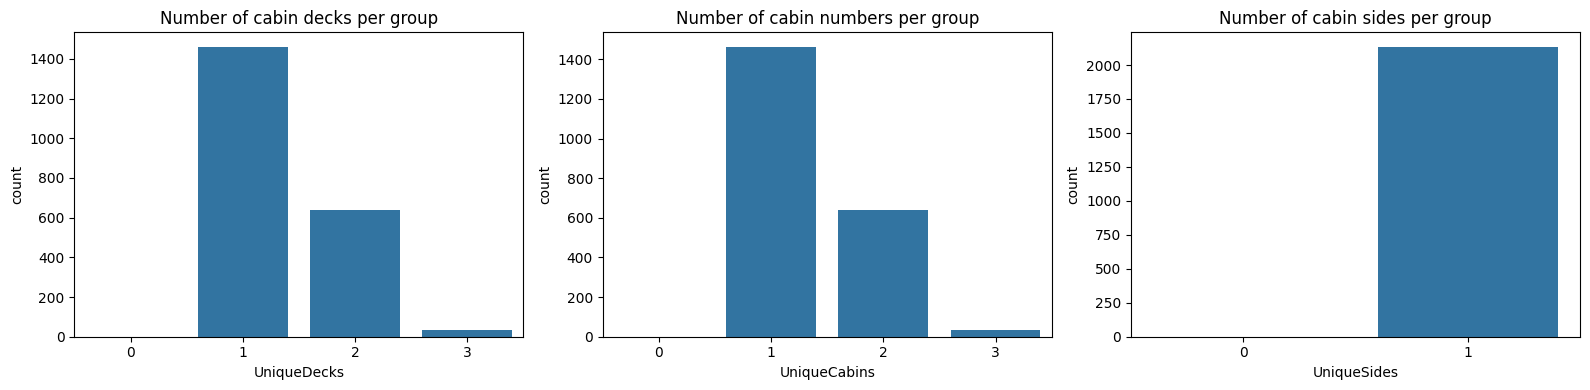

In [284]:
decks_per_group = (
    groups.groupby("GroupID")["Deck"].nunique().reset_index(name="UniqueDecks")
)
cabins_per_group = (
    groups.groupby("GroupID")["CabinNum"].nunique().reset_index(name="UniqueCabins")
)
sides_per_group = (
    groups.groupby("GroupID")["Side"].nunique().reset_index(name="UniqueSides")
)

fig = plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
sns.countplot(x="UniqueDecks", data=decks_per_group)
plt.title("Number of cabin decks per group")

plt.subplot(1, 3, 2)
sns.countplot(x="UniqueCabins", data=cabins_per_group)
plt.title("Number of cabin numbers per group")

plt.subplot(1, 3, 3)
sns.countplot(x="UniqueSides", data=sides_per_group)
plt.title("Number of cabin sides per group")

fig.tight_layout()
plt.show()

Most of the groups are travelling in the same cabin or deck, though it is not true for all of them. But they are in the same side. Unexpected finding. Let's proceed with `Side` imputation.

In [285]:
group_side_mapping = groups.groupby("GroupID")["Side"].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)

data.loc[data["Side"].isnull(), "Side"] = data.loc[
    data["Side"].isnull(), "GroupID"
].map(group_side_mapping)

data[["Side"]].isnull().sum()

Side    162
dtype: int64

So, are `Deck`, `Cabin Number` or `Side` related to `VIP` status?

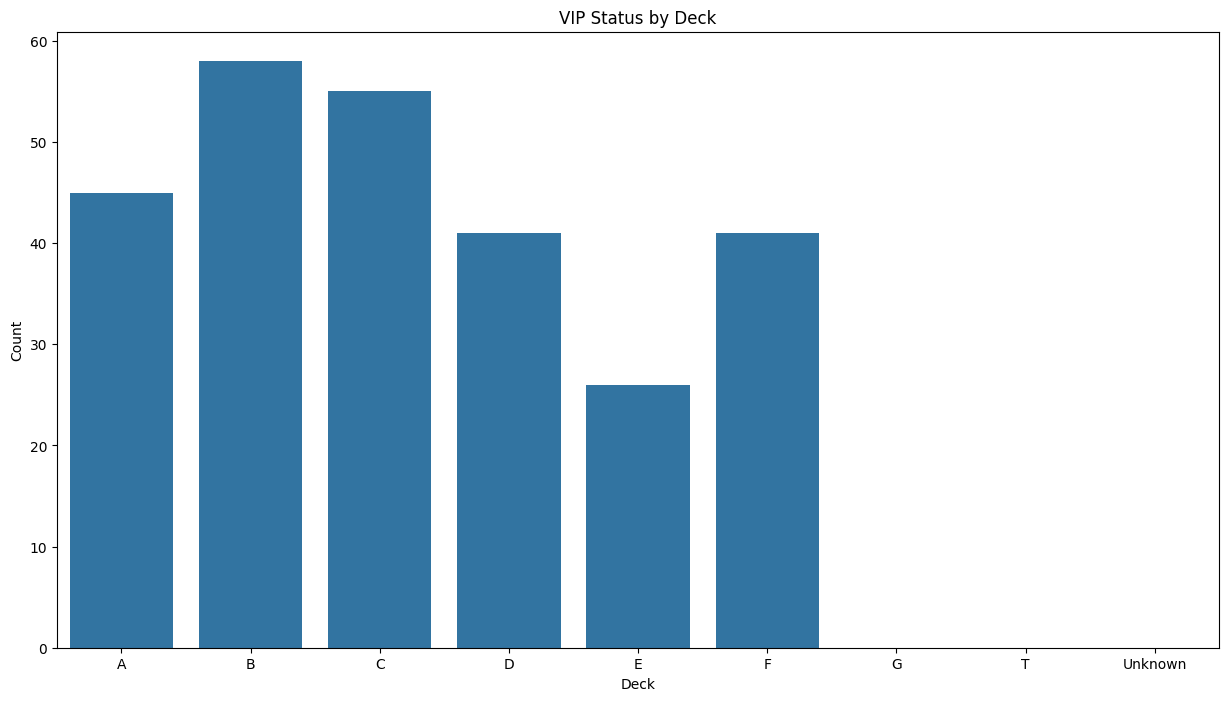

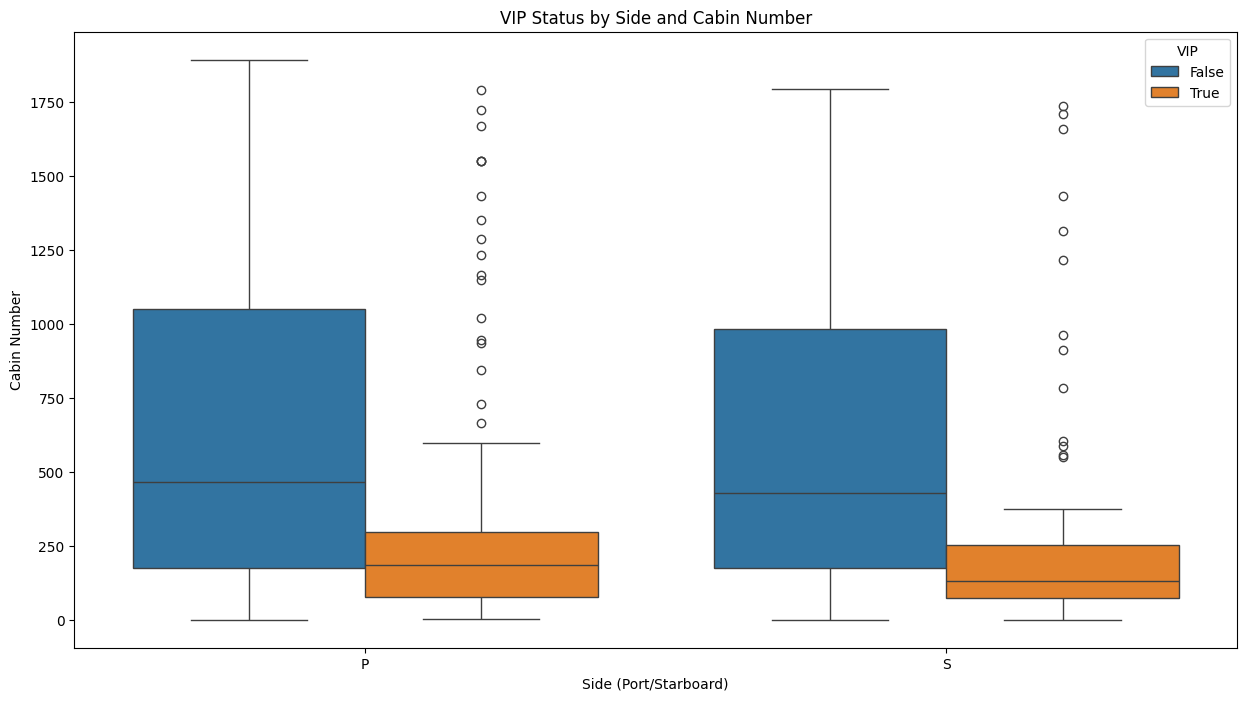

In [286]:
plt.figure(figsize=(15, 8))
sns.countplot(
    x="Deck",
    data=data[data['VIP'] == True],
    order=sorted(data["Deck"].fillna("Unknown").astype(str).unique()),
)
plt.title("VIP Status by Deck")
plt.xlabel("Deck")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(15, 8))
sns.boxplot(x="Side", y="CabinNum", hue="VIP", data=data)
plt.title("VIP Status by Side and Cabin Number")
plt.xlabel("Side (Port/Starboard)")
plt.ylabel("Cabin Number")
plt.show()

There are no VIP in Deck T (that is supposedly reserved for some special category, maybe spaceship employees?) or G, and they tend to be placed in lower number cabins, even though there are a lot of outliers.

In [287]:
data.loc[(data["VIP"].isnull()) & (data["Deck"].isin(["T", "G"]))]["VIP"] = False

data[['VIP']].isnull().sum()

VIP    242
dtype: int64

Let's now consider that VIP status for passengers travelling in group in the same cabin. What is the rate?

In [288]:
adult_vip_consistency = groups[groups["Age"] >= 18].groupby("Cabin")["VIP"].nunique()

consistent_vip_cabins = adult_vip_consistency[adult_vip_consistency == 1].shape[0]

total_vip_cabins = adult_vip_consistency.shape[0]

proportion_consistent_vip_cabins = consistent_vip_cabins / total_vip_cabins
proportion_consistent_vip_cabins

0.9461974110032363

It is surely not precise, but still a better option than imputing the mode for all the missing VIP statuses.

In [289]:
groups_with_vip = groups[groups["VIP"] == True]["GroupID"].unique()

null_in_vip_groups = (
    (data["GroupID"].isin(groups_with_vip))
    & (data["Age"] >= 18)
    & (data["VIP"].isnull())
)

data[null_in_vip_groups].shape[0]

2

It's just 2 passengers, so we can impute VIP status for them.

In [290]:
data.loc[null_in_vip_groups, "VIP"] = True

data[["VIP"]].isnull().sum()

VIP    240
dtype: int64

In [291]:
groups_with_no_vip = groups[groups["VIP"] == False]["GroupID"].unique()

null_in_non_vip_groups = (
    (data["GroupID"].isin(groups_with_no_vip))
    & (data["Age"] >= 18)
    & (data["VIP"].isnull())
)

data[null_in_non_vip_groups].shape[0]

84

In [292]:
data.loc[null_in_non_vip_groups, "VIP"] = False

data[["VIP"]].isnull().sum()

VIP    156
dtype: int64

It seems legit that the passengers from the same family share the same `VIP` status. Let's see if it is a correct assumption.

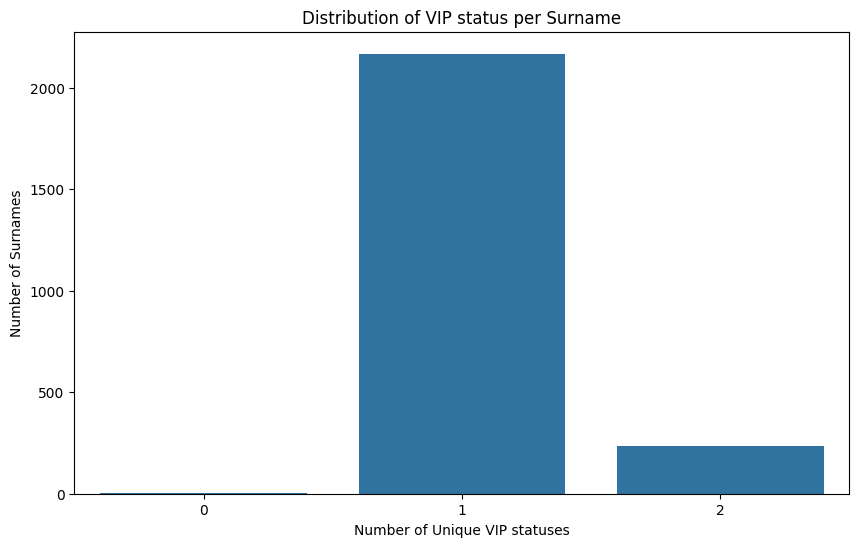

In [293]:
VIPstatus_per_surname = data.groupby("Surname")["VIP"].nunique()

plt.figure(figsize=(10, 6))
sns.countplot(x=VIPstatus_per_surname)
plt.title("Distribution of VIP status per Surname")
plt.xlabel("Number of Unique VIP statuses")
plt.ylabel("Number of Surnames")
plt.show()

It seems the largest part share the same status, either true or false. Let's quantify them.

In [294]:
family_vip_consistency = data.groupby(["Surname"])["VIP"].nunique()

consistent_vip_families = family_vip_consistency[family_vip_consistency == 1].shape[0]

total_vip_families = family_vip_consistency.shape[0]

proportion_consistent_vip_families = consistent_vip_families / total_vip_families
proportion_consistent_vip_families

0.9006650041562759

We will then impute, even if we introduce a small error, the `VIP` status for passengers according to family.

In [295]:
families_with_vip = data[(data["VIP"] == True)]["Surname"].unique()

null_in_vip_families = (data["Surname"].isin(families_with_vip)) & (
    data["VIP"].isnull()
)

data[null_in_vip_families].shape[0]

13

In [296]:
data.loc[null_in_vip_families, "VIP"] = True

data[["VIP"]].isnull().sum()

VIP    143
dtype: int64

In [297]:
families_with_non_vip = data[(data["VIP"] == False)]["Surname"].unique()

null_in_non_vip_families = (data["Surname"].isin(families_with_non_vip)) & (
    data["VIP"].isnull()
)

data[null_in_non_vip_families].shape[0]

138

In [298]:
data.loc[null_in_non_vip_families, "VIP"] = False

data[["VIP"]].isnull().sum()

VIP    5
dtype: int64

It seems legit to use the expenses to determine VIP status, let's see if they are of any help.

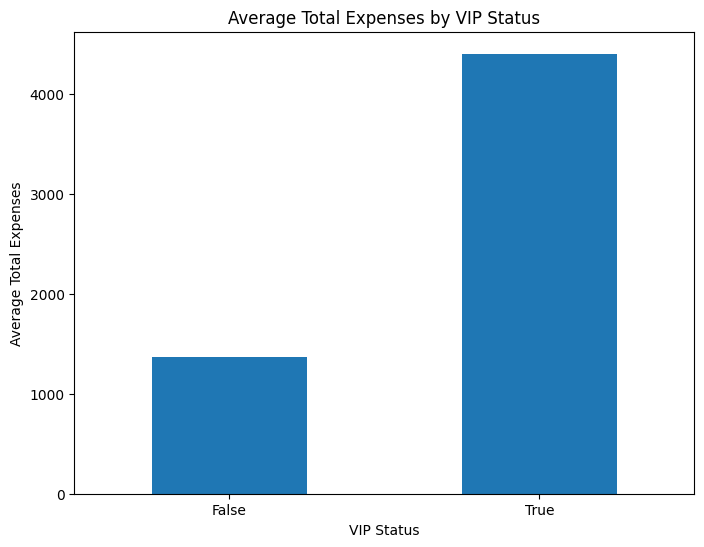

In [299]:
total_expenses_by_vip = data.groupby("VIP")["TotalExpenses"].mean()

plt.figure(figsize=(8, 6))
total_expenses_by_vip.plot(kind="bar")
plt.title("Average Total Expenses by VIP Status")
plt.xlabel("VIP Status")
plt.ylabel("Average Total Expenses")
plt.xticks(rotation=0)
plt.show()

There's indeed a huge difference in the average, but is it enough to impute the missing values?

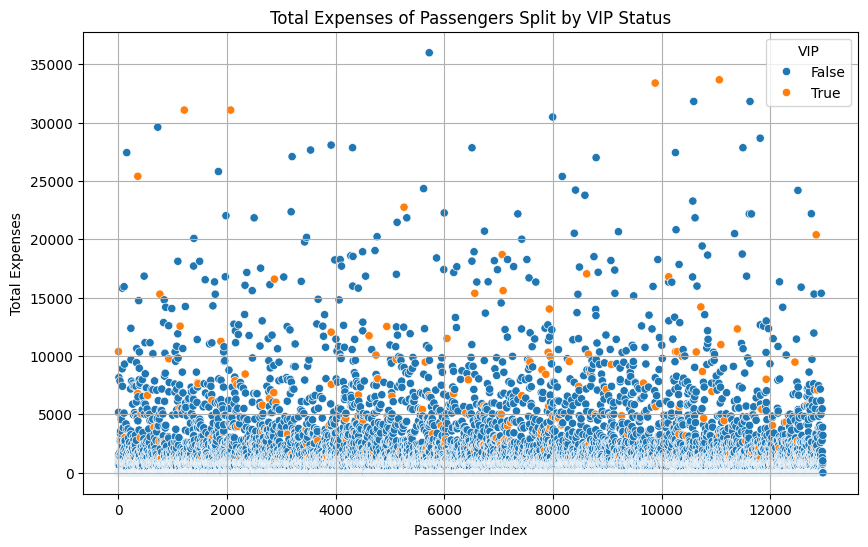

In [300]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data.index, y=data["TotalExpenses"], hue=data["VIP"])
plt.title("Total Expenses of Passengers Split by VIP Status")
plt.xlabel("Passenger Index")
plt.ylabel("Total Expenses")
plt.grid(True)

plt.show()

The total expenses scatterplot is not really of any use, maybe some of the single expenses voices could be more useful.

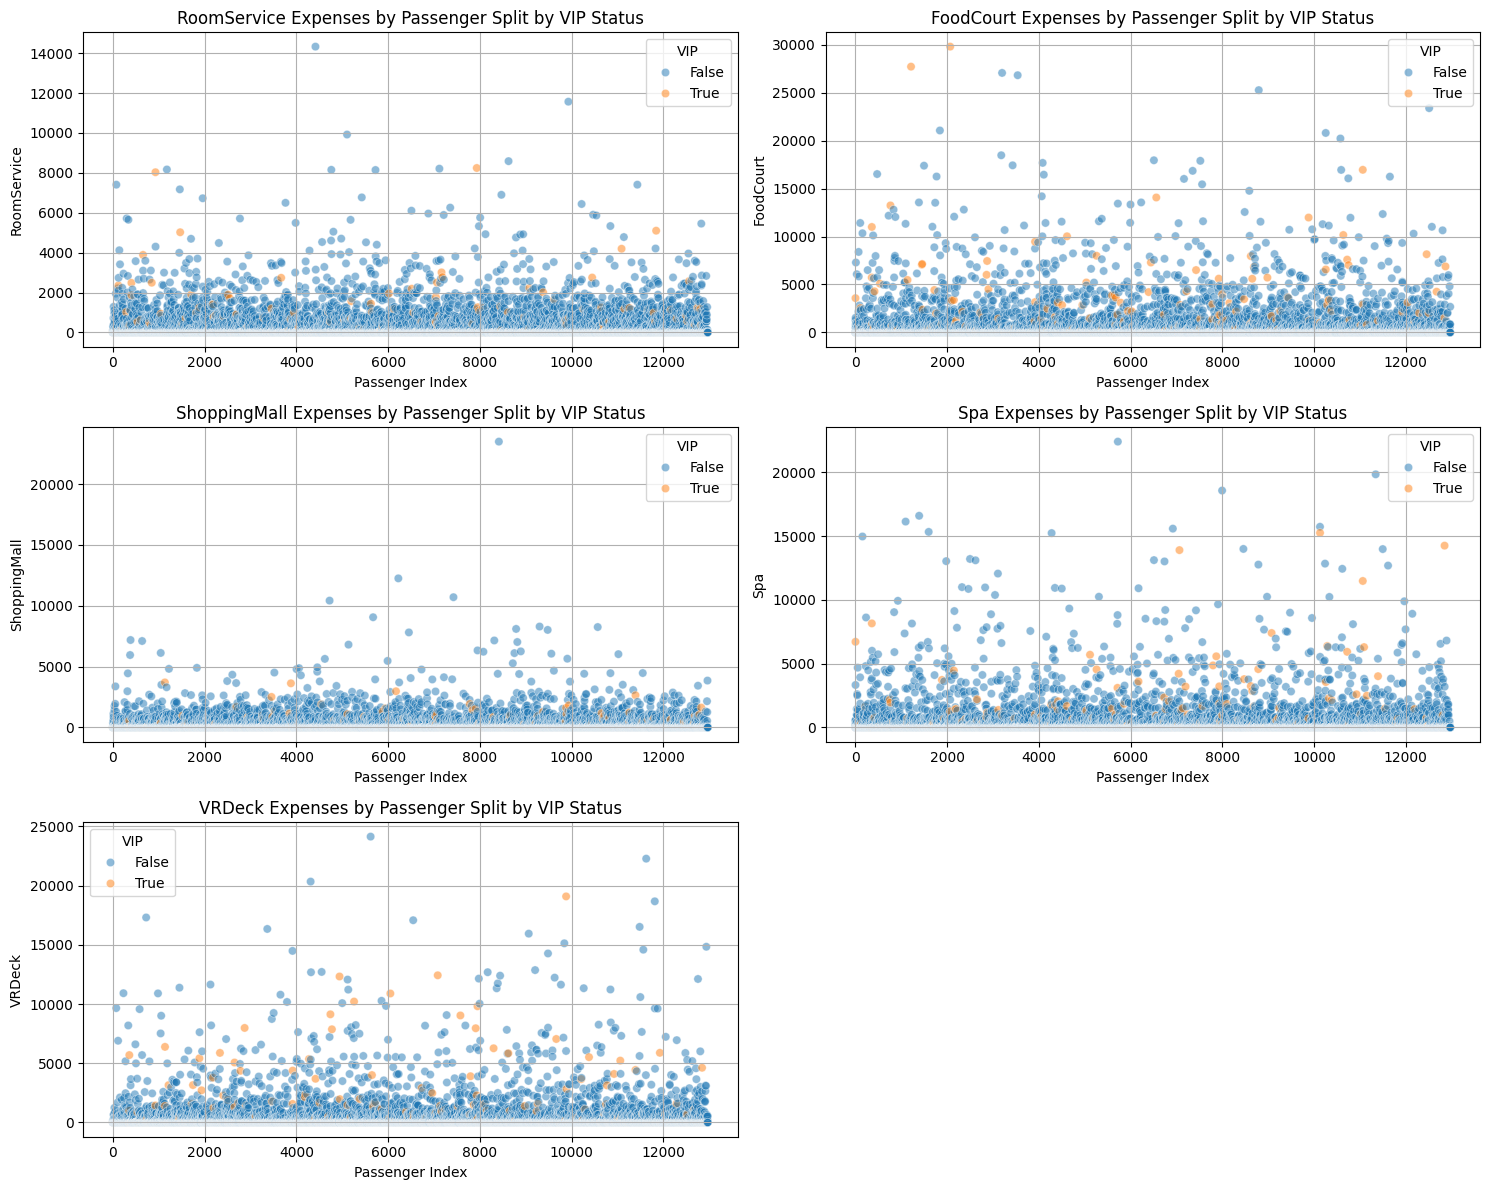

In [301]:
plt.figure(figsize=(15, 12))

for i, column in enumerate(services, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=data.index, y=data[column], hue=data["VIP"], alpha=0.5)
    plt.title(f"{column} Expenses by Passenger Split by VIP Status")
    plt.xlabel("Passenger Index")
    plt.ylabel(column)
    plt.grid(True)

plt.tight_layout()
plt.show()

We can only notice that VIP passengers are the highest spenders in Food Court, but nothing more than this, let's use a boxplot without outliers.

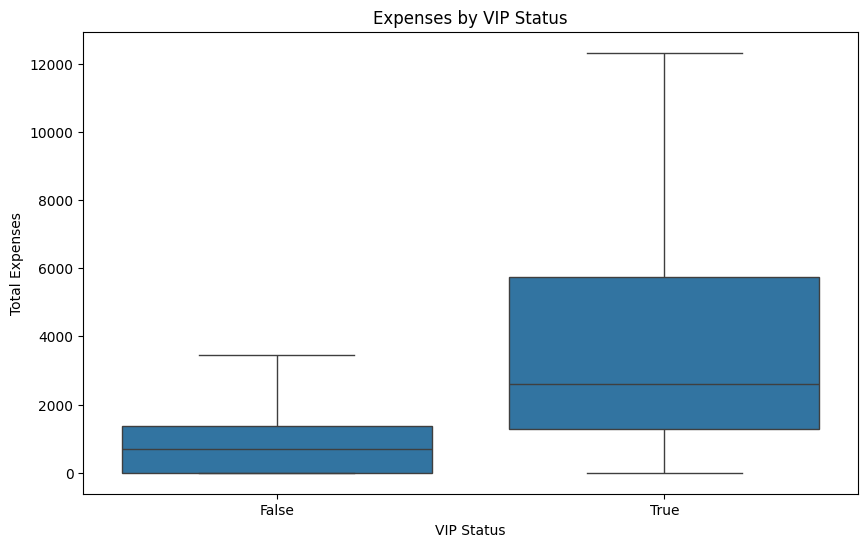

In [302]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="VIP", y="TotalExpenses", data=data, showfliers=False)
plt.title("Expenses by VIP Status")
plt.xlabel("VIP Status")
plt.ylabel("Total Expenses")
plt.show()

We see that the distribution is very different, but there is still an overlap that doesn't let us impute with certainty the VIP status. Maybe single expenses will come in help.

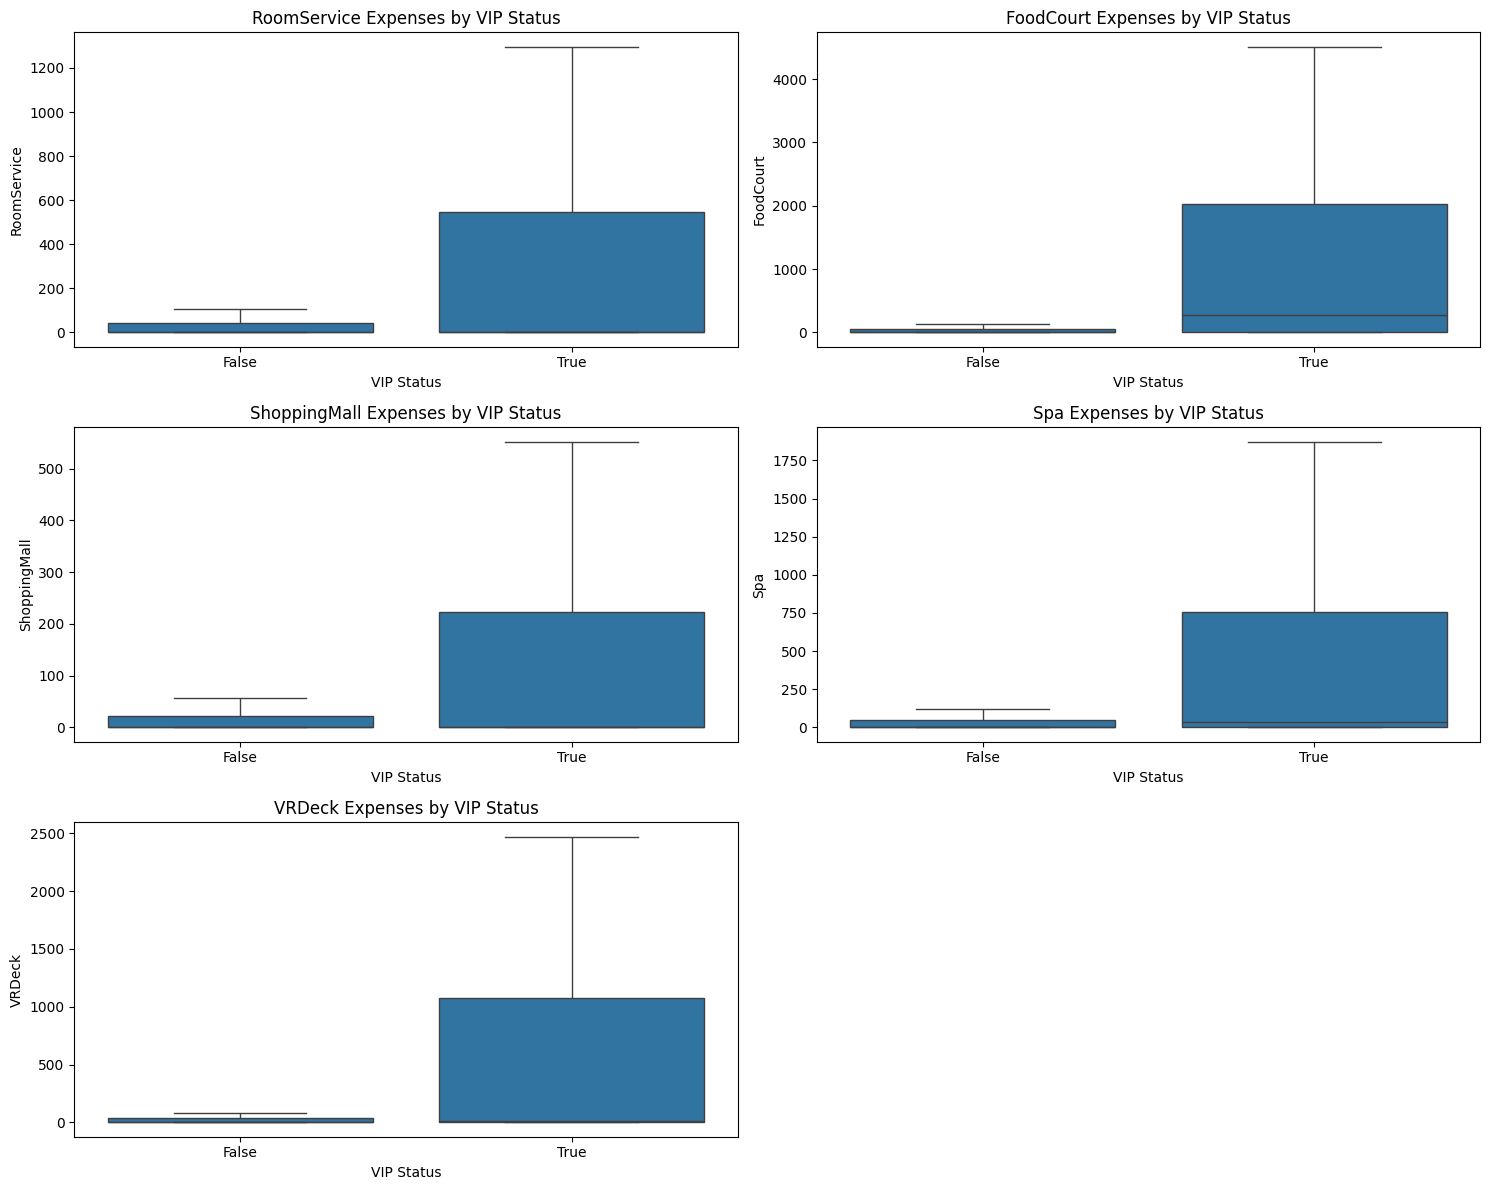

In [303]:
plt.figure(figsize=(15, 12))

for i, column in enumerate(services, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x="VIP", y=column, data=data, showfliers=False)
    plt.title(f"{column} Expenses by VIP Status")
    plt.xlabel("VIP Status")
    plt.ylabel(column)

plt.tight_layout()
plt.show()

It seems like the upper whisker of non VIP expenses in FoodCourt is smaller than the median of VIP. We could impute VIP status to all passengers spending more than that value, but to prevent data leakage let's see if this is valid for both datasets

Train dataset:
VIP mean FoodCourt expense: 1747.22
Non-VIP mean FoodCourt expense: 422.73
VIP median FoodCourt expense: 280.00
Non-VIP FoodCourt expense upper whisker: 132.50

Test dataset:
VIP mean FoodCourt expense: 1623.81
Non-VIP mean FoodCourt expense: 412.39
VIP median FoodCourt expense: 129.50
Non-VIP FoodCourt expense upper whisker: 157.50



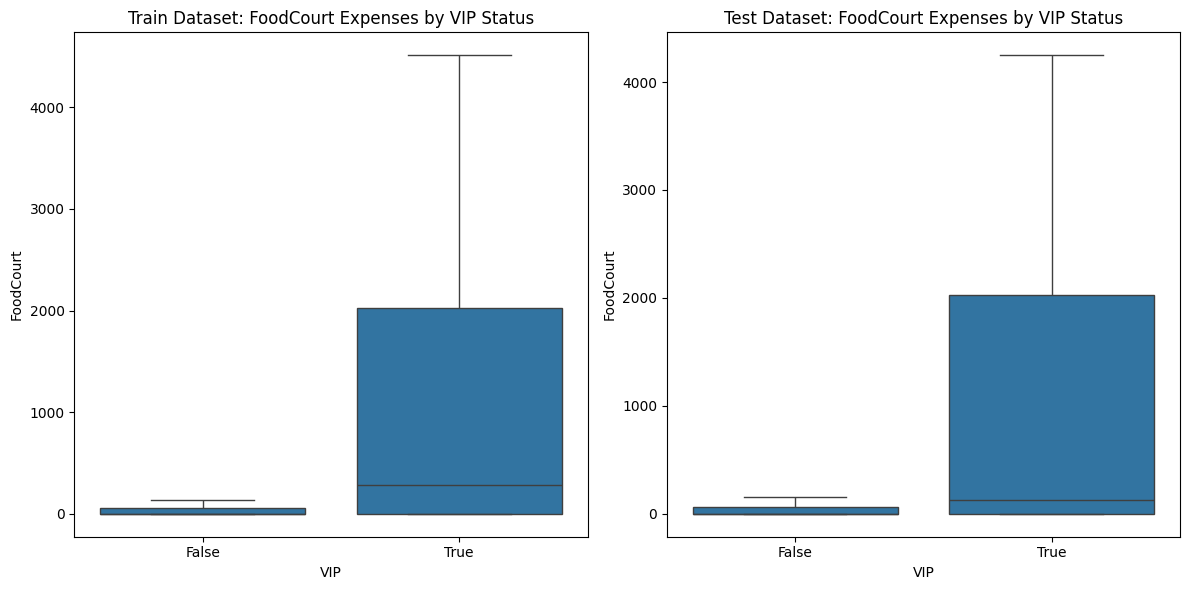

In [304]:
train_data = data[data["Transported"].notna()]
test_data = data[data["Transported"].isna()]

def print_stats(df, name):
    vip_food = df[df["VIP"] == True]["FoodCourt"]
    non_vip_food = df[df["VIP"] == False]["FoodCourt"]
    Q1 = non_vip_food.quantile(0.25)
    Q3 = non_vip_food.quantile(0.75)

    IQR = Q3 - Q1

    upper_whisker = Q3 + 1.5 * IQR
    print(f"{name} dataset:")
    print(f"VIP mean FoodCourt expense: {vip_food.mean():.2f}")
    print(f"Non-VIP mean FoodCourt expense: {non_vip_food.mean():.2f}")
    print(f"VIP median FoodCourt expense: {vip_food.median():.2f}")
    print(f"Non-VIP FoodCourt expense upper whisker: {upper_whisker:.2f}")
    print()


print_stats(train_data, "Train")
print_stats(test_data, "Test")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x="VIP", y="FoodCourt", data=train_data, showfliers=False)
plt.title("Train Dataset: FoodCourt Expenses by VIP Status")

plt.subplot(1, 2, 2)
sns.boxplot(x="VIP", y="FoodCourt", data=test_data, showfliers=False)
plt.title("Test Dataset: FoodCourt Expenses by VIP Status")

plt.tight_layout()
plt.show()

It is not valid assumption, so we will impute the rest later after splitting.

### ***Destination***

The first logical step would be to search for `Destination` in groups of passengers travelling together, they are from the same `HomPlanet` and probably they are heading to the same final place.

In [305]:
group_destination_consistency = (
    data[data["GroupSize"] > 1].groupby("GroupID")["Destination"].nunique()
)

consistent_destination_groups = (group_destination_consistency == 1).sum()
total_groups = group_destination_consistency.shape[0]
proportion_consistent_destination_groups = consistent_destination_groups / total_groups

print(
    f"Proportion of groups with consistent Destination: {proportion_consistent_destination_groups:.2f}"
)

Proportion of groups with consistent Destination: 0.50


It seems we were totally wrong, even half of the groups have passengers travelling to different destinations.

In [306]:
groups_with_different_destinations = groups.groupby("GroupID")["Destination"].nunique()
groups_with_different_destinations = groups_with_different_destinations[
    groups_with_different_destinations > 1
].index

different_destination_groups = groups[
    groups["GroupID"].isin(groups_with_different_destinations)
]

different_destination_groups.shape[0]

3292

Maybe the key is the `Cabin` more than the group, since some groups are travelling in separate locations.

In [307]:
cabin_destination_consistency = data.groupby(["Deck", "CabinNum", "Side"])[
    "Destination"
].nunique()

consistent_destination_cabins = (cabin_destination_consistency == 1).sum()
total_cabins = cabin_destination_consistency.shape[0]
proportion_consistent_destination_cabins = consistent_destination_cabins / total_cabins

print(
    f"Proportion of cabins with consistent Destination: {proportion_consistent_destination_cabins:.2f}"
)

Proportion of cabins with consistent Destination: 0.89


We are close here, but under the safety threshold of 0.9

Then maybe families are going to the same destination.

In [308]:
family_destination_consistency = data.groupby("Surname")["Destination"].nunique()

consistent_destination_families = (family_destination_consistency == 1).sum()
total_families = family_destination_consistency.shape[0]
proportion_consistent_destination_families = (
    consistent_destination_families / total_families
)

print(
    f"Proportion of families with consistent Destination: {proportion_consistent_destination_families:.2f}"
)

Proportion of families with consistent Destination: 0.32


That's even less true, it seems harder to find a simple correlation this time, maybe the `HomePlanet` can be relevant, even though it is shared by families and groups and they were not consistent in destination.

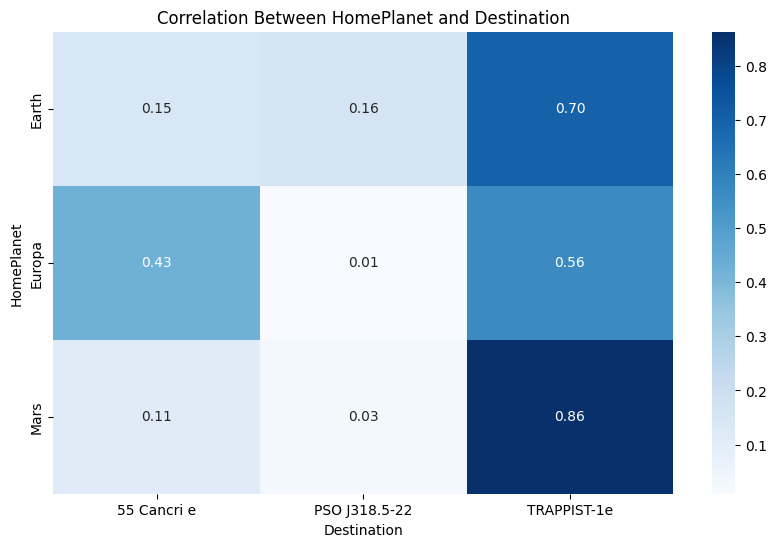

In [309]:
homeplanet_destination_correlation = pd.crosstab(
    data["HomePlanet"], data["Destination"], normalize="index"
)

plt.figure(figsize=(10, 6))
sns.heatmap(homeplanet_destination_correlation, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Between HomePlanet and Destination")
plt.xlabel("Destination")
plt.ylabel("HomePlanet")
plt.show()

We see that most of the passengers leaving from Mars are heading to TRAPPIST-1e, which is the favourite destination of passengers travelling from the other planets/satellite as well. PSO J318.5-22 is not quite requested, especially by people from Europa.

We can use these rates for further imputing if we don't find better info.

Is `VIP` status important?

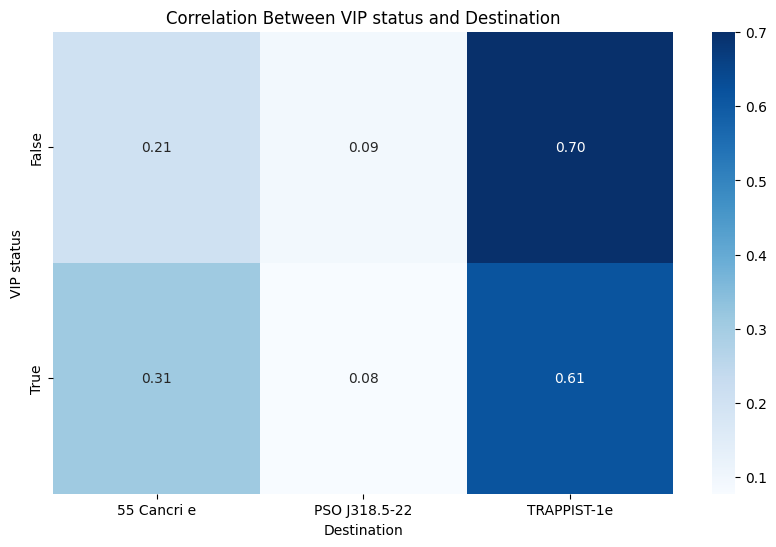

In [310]:
vip_destination_correlation = pd.crosstab(
    data["VIP"], data["Destination"], normalize="index"
)

plt.figure(figsize=(10, 6))
sns.heatmap(vip_destination_correlation, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Between VIP status and Destination")
plt.xlabel("Destination")
plt.ylabel("VIP status")
plt.show()

We see some preferences in destination, but still not enough to impute with some level of certainty.

Can `TotalExpenses` be finally the right feature? We will split into chunks because it is easier to visualize.

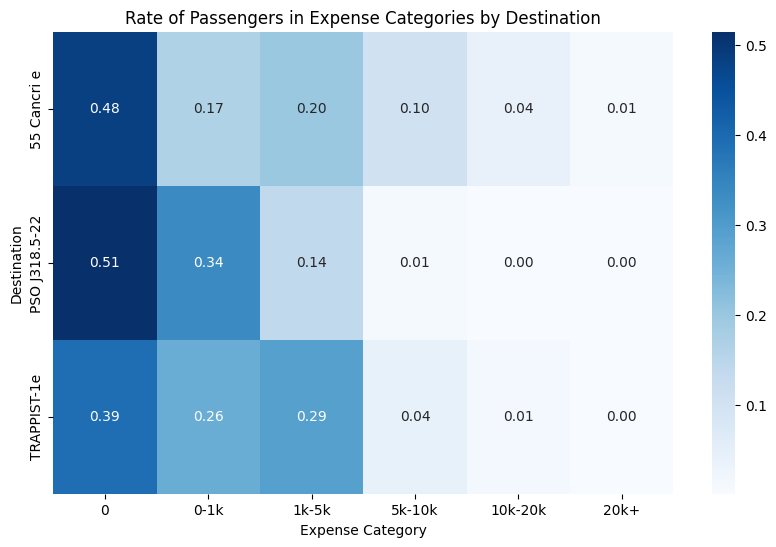

In [311]:
data["ExpenseCategory"] = pd.cut(
    data["TotalExpenses"],
    bins=[-0.1, 0, 1000, 5000, 10000, 20000, float("inf")],
    labels=["0", "0-1k", "1k-5k", "5k-10k", "10k-20k", "20k+"],
)

filtered_data = data[data["TotalExpenses"].notnull()]

total_passengers_per_destination = filtered_data["Destination"].value_counts()

expense_destination_counts = (
    filtered_data.groupby(["Destination", "ExpenseCategory"])
    .size()
    .unstack(fill_value=0)
)

expense_destination_rates = expense_destination_counts.div(
    total_passengers_per_destination, axis=0
)

plt.figure(figsize=(10, 6))
sns.heatmap(expense_destination_rates, annot=True, cmap="Blues", fmt=".2f")
plt.title("Rate of Passengers in Expense Categories by Destination")
plt.xlabel("Expense Category")
plt.ylabel("Destination")
plt.show()

Again not enough. It is harder than we could preventivate.

Hopefully there is a correlation between `CryoSleep` status and `Destination`

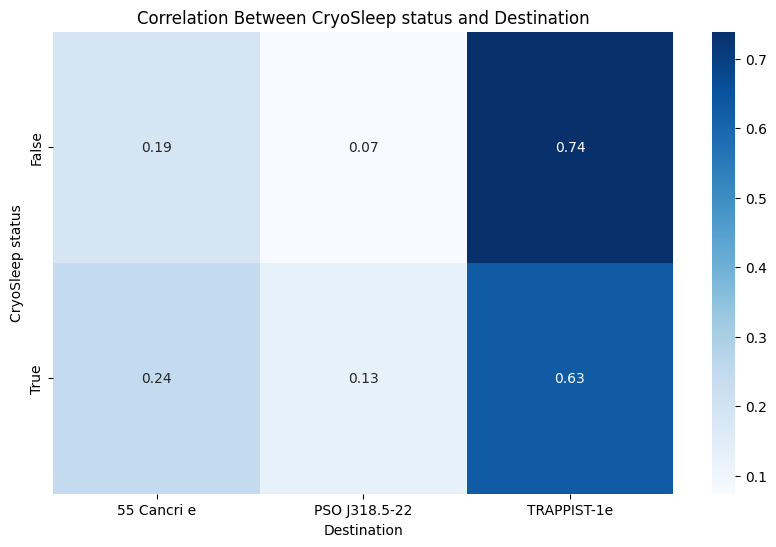

In [312]:
vip_destination_correlation = pd.crosstab(
    data["CryoSleep"], data["Destination"], normalize="index"
)

plt.figure(figsize=(10, 6))
sns.heatmap(vip_destination_correlation, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Between CryoSleep status and Destination")
plt.xlabel("Destination")
plt.ylabel("CryoSleep status")
plt.show()

We don't have sufficient evidences to impute destination according to these relationships.
Let's see if combining with `HomePlanet` we have more information.

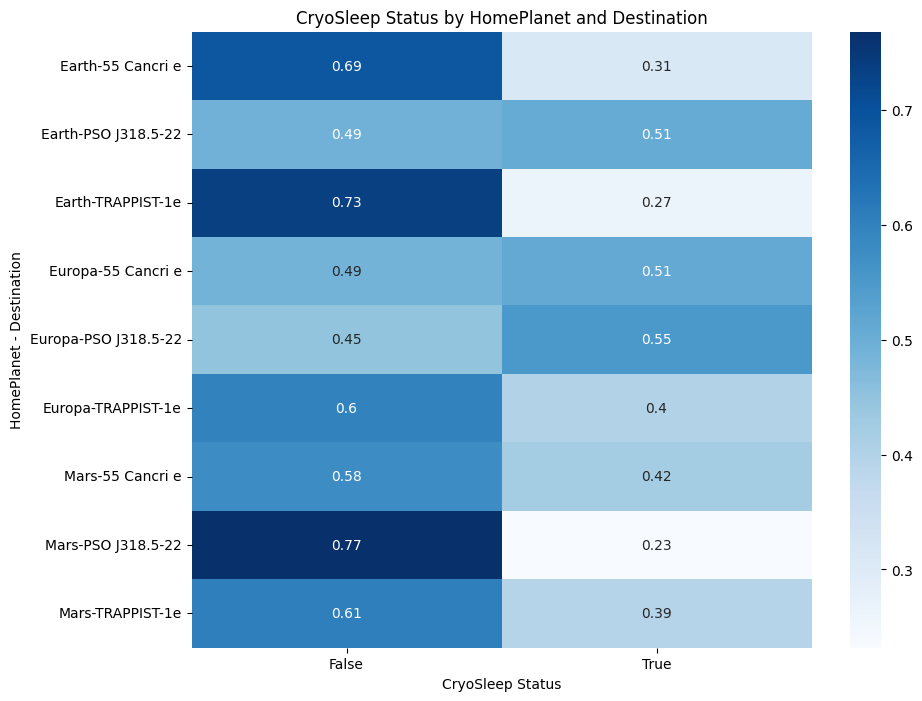

In [313]:
data2 = data.dropna(subset=["HomePlanet", "Destination"])

crosstab = pd.crosstab(
    index=[data2["HomePlanet"], data2["Destination"]],
    columns=data2["CryoSleep"],
    normalize="index",
)

plt.figure(figsize=(10, 8))
sns.heatmap(crosstab, annot=True, cmap="Blues", cbar=True)
plt.title("CryoSleep Status by HomePlanet and Destination")
plt.ylabel("HomePlanet - Destination")
plt.xlabel("CryoSleep Status")
plt.show()

We will then impute `Destination` later following some reasonable logic.

### ***Deck, Cabin, Side***

We could impute part of the Sides, let's find something useful for a furher imputation.

In [314]:
data[["CabinNum", "Deck", "Side"]].isnull().sum()

CabinNum    299
Deck        299
Side        162
dtype: int64

Similarly as we have previously done with groups, let's see if there is a consistency in cabins position for families.

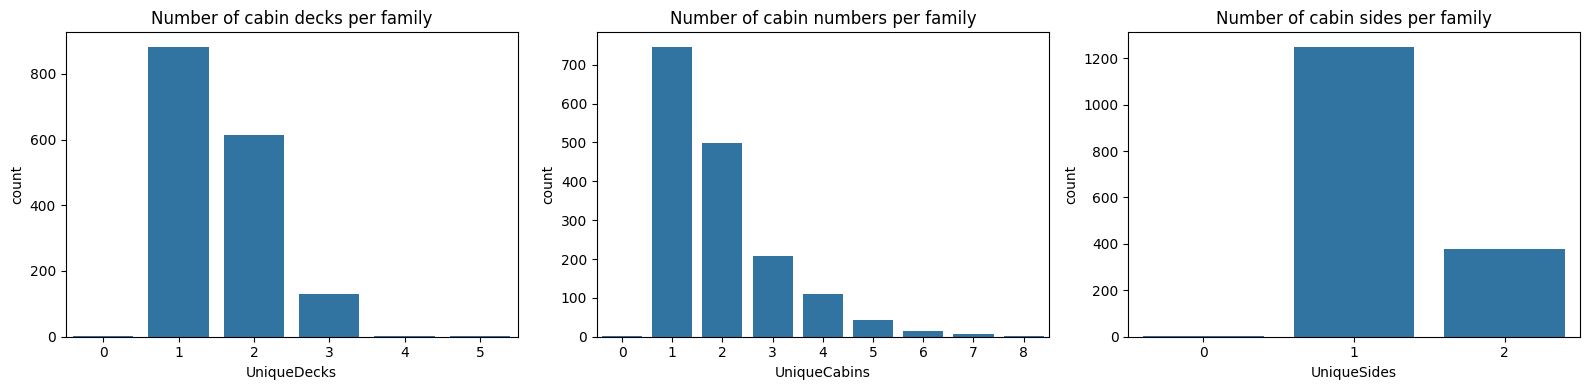

In [315]:
decks_per_family = (
    groups.groupby("Surname")["Deck"].nunique().reset_index(name="UniqueDecks")
)
cabins_per_family = (
    groups.groupby("Surname")["CabinNum"].nunique().reset_index(name="UniqueCabins")
)
sides_per_family = (
    groups.groupby("Surname")["Side"].nunique().reset_index(name="UniqueSides")
)

fig = plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
sns.countplot(x="UniqueDecks", data=decks_per_family)
plt.title("Number of cabin decks per family")

plt.subplot(1, 3, 2)
sns.countplot(x="UniqueCabins", data=cabins_per_family)
plt.title("Number of cabin numbers per family")

plt.subplot(1, 3, 3)
sns.countplot(x="UniqueSides", data=sides_per_family)
plt.title("Number of cabin sides per family")

fig.tight_layout()
plt.show()

As for groups we see that for passengers with the same surname we have multiple values for decks and cabins, in this case we unfortunately don't have a single side distribution.

We have seen that VIP passengers tend to have a smaller cabin number, is there some relationship with expenses?

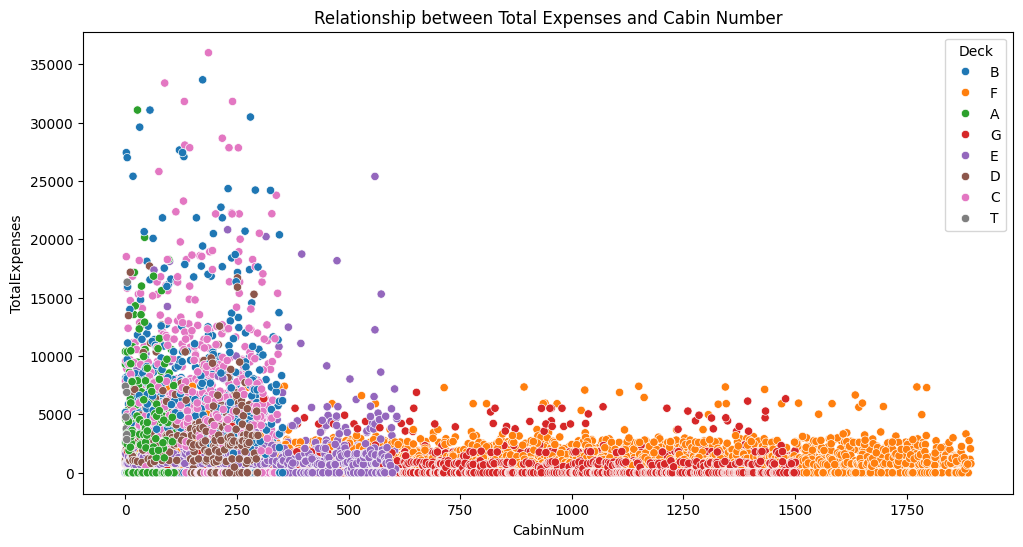

In [316]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x="CabinNum", y="TotalExpenses", hue="Deck", data=data)
plt.title("Relationship between Total Expenses and Cabin Number")
plt.show()

We see similar threshold as in the Cabin Number vs Transported chart, we previously saw an inversion of the target variable, in this case we notice a clear difference in expensive or deck.
We will then create a new ordinal feature, to prevent bloating the dataset after hot encoding.

In [317]:
def cabin_to_ordinal(cabin_num):
    if pd.isna(cabin_num):
        return np.nan
    elif cabin_num <= 300:
        return 1
    elif cabin_num <= 600:
        return 2
    elif cabin_num <= 1200:
        return 3
    elif cabin_num <= 1500:
        return 4
    else:
        return 5


data["CabinOrdinal"] = data["CabinNum"].apply(cabin_to_ordinal)

data.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

  Transported GroupID  GroupSize  IsAlone Deck  CabinNum Side  TotalExpenses  \
0       False    0001          1     True    B       0.0    P            0.0   
1        True    0002          1     True    F       0.0    S          736.0   
2       False    0003          2    False    A       0.0    S        10383.0   
3       False    0003          2    False    A       0.0    S         5176.0   
4        True    0004          1     True    F       1.0    S         1091.0   

   IsSpending      Surname ExpenseCategory  CabinOrdinal  
0       False    Ofracculy               0           1.0  
1        True        Vines            0-1k           1.0  
2        True       Susent         10k-20k           1.0  
3        True       Susent          5k-10k           1.0  
4        True  Santantines           1k-5k           1.0

Is the amount of expenses, and mybe of `VIP` status as well, related to `Deck` assignment?

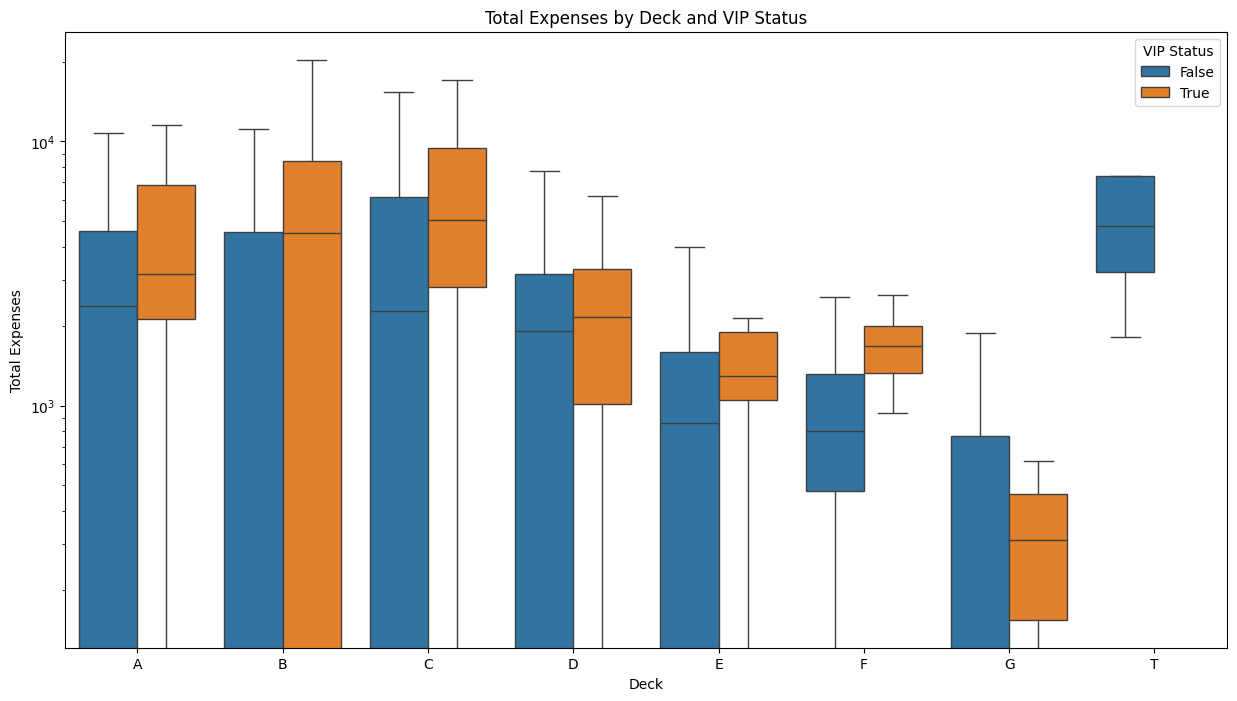

In [318]:
plt.figure(figsize=(15, 8))
sns.boxplot(
    x="Deck",
    y="TotalExpenses",
    hue="VIP",
    data=data,
    order=sorted(data["Deck"].dropna().astype(str).unique()),
    showfliers=False,
)
plt.title("Total Expenses by Deck and VIP Status")
plt.xlabel("Deck")
plt.ylabel("Total Expenses")
plt.yscale("log") 
plt.legend(title="VIP Status")
plt.show()

Passengers in Deck T are probably some special category, not employees since they are high spenders and none of them is a VIP. But there is not a clear pattern in Deck assignment.

Let's see if there is a relationship with groups.

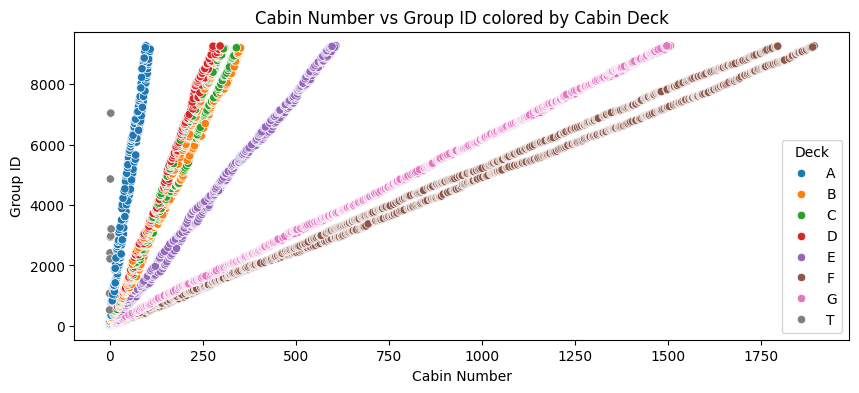

In [319]:
data["GroupID"] = pd.to_numeric(data["GroupID"], errors="coerce")

plt.figure(figsize=(10, 4))

plot_data = data.dropna(subset=["CabinNum", "Deck"])

le = LabelEncoder()
plot_data["Deck_encoded"] = le.fit_transform(plot_data["Deck"])

sns.scatterplot(
    x="CabinNum", y="GroupID", hue="Deck_encoded", data=plot_data, palette="tab10"
)

plt.title("Cabin Number vs Group ID colored by Cabin Deck")
plt.xlabel("Cabin Number")
plt.ylabel("Group ID")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, le.classes_, title="Deck")

plt.show()

It seems we have found an interestin linear relationship between the `Cabin Number` and the `GroupID`. We will use it in the imputing pipeline.

## ***Data Imputation***

Let's see with how many null values we are left.

In [320]:
data.isnull().sum()

PassengerId           0
HomePlanet            0
CryoSleep            55
Cabin               299
Destination         274
Age                 270
VIP                   5
RoomService         162
FoodCourt           171
ShoppingMall        163
Spa                 166
VRDeck              150
Name                294
Transported        4277
GroupID               0
GroupSize             0
IsAlone               0
Deck                299
CabinNum            299
Side                162
TotalExpenses         0
IsSpending            0
Surname             294
ExpenseCategory       0
CabinOrdinal        299
dtype: int64

From now on we will not be needing `PassengerId`, `Cabin`, `Name` and `Surname` features, so let's drop them.

In [321]:
data.drop(["PassengerId", "Cabin", "Name", "Surname"], axis=1, inplace=True)

Let's split back train dataset and test dataset.

In [322]:
train_data = data[~data["Transported"].isnull()]
test_data = data[data["Transported"].isnull()]

test_data.head()

HomePlanet CryoSleep  Destination   Age    VIP  RoomService  FoodCourt  \
8693      Earth      True  TRAPPIST-1e  27.0  False          0.0        0.0   
8694      Earth     False  TRAPPIST-1e  19.0  False          0.0        9.0   
8695     Europa      True  55 Cancri e  31.0  False          0.0        0.0   
8696     Europa     False  TRAPPIST-1e  38.0  False          0.0     6652.0   
8697      Earth     False  TRAPPIST-1e  20.0  False         10.0        0.0   

      ShoppingMall     Spa  VRDeck Transported  GroupID  GroupSize  IsAlone  \
8693           0.0     0.0     0.0         NaN       13          1     True   
8694           0.0  2823.0     0.0         NaN       18          1     True   
8695           0.0     0.0     0.0         NaN       19          1     True   
8696           0.0   181.0   585.0         NaN       21          1     True   
8697         635.0     0.0     0.0         NaN       23          1     True   

     Deck  CabinNum Side  TotalExpenses  IsSpending ExpenseCategory  \
8693    G       3.0    S            0.0       False               0   
8694    F       4.0    S         2832.0        True           1k-5k   
8695    C       0.0    S            0.0       False               0   
8696    C       1.0    S         7418.0        True          5k-10k   
8697    F       5.0    S          645.0        True            0-1k   

      CabinOrdinal  
8693           1.0  
8694           1.0  
8695           1.0  
8696           1.0  
8697           1.0

In [323]:
train_data.head()

HomePlanet CryoSleep  Destination   Age    VIP  RoomService  FoodCourt  \
0     Europa     False  TRAPPIST-1e  39.0  False          0.0        0.0   
1      Earth     False  TRAPPIST-1e  24.0  False        109.0        9.0   
2     Europa     False  TRAPPIST-1e  58.0   True         43.0     3576.0   
3     Europa     False  TRAPPIST-1e  33.0  False          0.0     1283.0   
4      Earth     False  TRAPPIST-1e  16.0  False        303.0       70.0   

   ShoppingMall     Spa  VRDeck Transported  GroupID  GroupSize  IsAlone Deck  \
0           0.0     0.0     0.0       False        1          1     True    B   
1          25.0   549.0    44.0        True        2          1     True    F   
2           0.0  6715.0    49.0       False        3          2    False    A   
3         371.0  3329.0   193.0       False        3          2    False    A   
4         151.0   565.0     2.0        True        4          1     True    F   

   CabinNum Side  TotalExpenses  IsSpending ExpenseCategory  CabinOrdinal  
0       0.0    P            0.0       False               0           1.0  
1       0.0    S          736.0        True            0-1k           1.0  
2       0.0    S        10383.0        True         10k-20k           1.0  
3       0.0    S         5176.0        True          5k-10k           1.0  
4       1.0    S         1091.0        True           1k-5k           1.0

We will create an imputing pipeline to fill the missing values without the risk of incurring in data leakage.

In [324]:
DEBUG = True  # Set to False to disable debug output

def debug(*args):
    """Prints the message if DEBUG is True."""
    if DEBUG:
        print(" ".join(map(str, args)))

class ImputationError(Exception):
    pass

We needed to implement a debug system because the process of creating custom imputing classes has been not flawless.

Let's define some custom imputing classes to fill the missing values.

The `CustomCategoricalImputer` class is designed to handle missing values in categorical features of a dataset.

- **Fitting the Imputer**:
  - Computes the mode (most frequent value) for each categorical column to use for imputation.
  - Calculates probabilities for the `CryoSleep`, `Destination`, and `Deck` features based on the relationships with other categorical features.

- **Transforming the Data**:
  - Imputes missing values in the `CryoSleep` column using the calculated probabilities.
  - Imputes missing values in the `Destination` and `Deck` columns based on the relationships defined during fitting.
  - Fills other categorical columns with their respective modes.

- **Helper Methods**:
  - Contains private methods to handle the imputation logic for `Destination` and `Deck` based on the calculated probabilities.


In [325]:
class CustomCategoricalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_columns: Optional[list[str]] = None) -> None:
        """
        Initializes the CustomCategoricalImputer with specified categorical columns.

        Parameters:
        - cat_columns: List of categorical column names to be imputed. If None, defaults to a predefined list.
        """
        if cat_columns is None:
            self.cat_columns = [
                "HomePlanet",
                "CryoSleep",
                "Destination",
                "VIP",
                "Deck",
                "Side",
                "IsAlone",
            ]
        else:
            self.cat_columns = cat_columns
        
        self.imputers: Dict[str, Any] = {}
        self.cryo_sleep_probs: Optional[Dict[str, float]] = None
        self.destination_probabilities: Optional[Dict[tuple, Dict[str, float]]] = None
        self.deck_probabilities: Optional[Dict[tuple, Dict[str, float]]] = None
        self.overall_destination_probs: Optional[Dict[str, float]] = None
        self.overall_deck_probs: Optional[Dict[str, float]] = None

    def get_feature_names_out(self, input_features: Optional[list[str]] = None) -> list[str]:
        """
        Returns the list of feature names that will be output by the transformer.

        Parameters:
        - input_features: Optional list of input feature names.

        Returns:
        - List of categorical feature names.
        """
        return self.cat_columns

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'CustomCategoricalImputer':
        """
        Fits the imputer on the provided DataFrame.

        Parameters:
        - X: DataFrame containing the data to fit on.
        - y: Optional target variable (not used in this imputer).

        Returns:
        - self: Fitted imputer instance.
        """
        try:
            debug("Fitting CustomCategoricalImputer")
            # Include 'IsAlone' in the columns
            X_ = X[self.cat_columns].copy()

            # Convert boolean columns to string
            for col in ["CryoSleep", "VIP", "IsAlone"]:
                if col in X_.columns and X_[col].dtype == bool:
                    X_[col] = X_[col].astype(str)

            # Impute modes for categorical columns
            for col in self.cat_columns:
                self.imputers[col] = (
                    X_[col].mode().iloc[0] if not X_[col].isnull().all() else "Unknown"
                )

            # CryoSleep probabilities
            self.cryo_sleep_probs = (
                X_["CryoSleep"].value_counts(normalize=True).to_dict()
            )

            # Destination probabilities
            self.destination_probabilities = (
                X_.groupby(["HomePlanet", "VIP", "CryoSleep"])["Destination"]
                .value_counts(normalize=True)
                .unstack(fill_value=0)
                .to_dict()
            )
            self.overall_destination_probs = (
                X_["Destination"].value_counts(normalize=True).to_dict()
            )

            # Deck probabilities
            self.deck_probabilities = (
                X_.groupby(
                    ["HomePlanet", "VIP", "Destination", "CryoSleep", "IsAlone"]
                )["Deck"]
                .value_counts(normalize=True)
                .unstack(fill_value=0)
                .to_dict()
            )
            self.overall_deck_probs = X_["Deck"].value_counts(normalize=True).to_dict()

            return self
        except Exception as e:
            debug(f"Error in CustomCategoricalImputer fit: {str(e)}")
            raise

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transforms the input DataFrame by imputing missing values.

        Parameters:
        - X: DataFrame containing the data to transform.

        Returns:
        - Transformed DataFrame with imputed values.
        """
        try:
            debug("Transforming with CustomCategoricalImputer")
            # Include 'IsAlone' in the columns
            X_ = X[self.cat_columns].copy()

            # Convert boolean columns to string
            for col in ["CryoSleep", "VIP", "IsAlone"]:
                if col in X_.columns and X_[col].dtype == bool:
                    X_[col] = X_[col].astype(str)

            # Impute CryoSleep first
            cryo_mask = X_["CryoSleep"].isnull()
            X_.loc[cryo_mask, "CryoSleep"] = np.random.choice(
                list(self.cryo_sleep_probs.keys()),
                size=cryo_mask.sum(),
                p=list(self.cryo_sleep_probs.values()),
            )

            # Impute other columns
            for col in self.cat_columns:
                if col == "Destination":
                    dest_mask = X_["Destination"].isnull()
                    X_.loc[dest_mask, "Destination"] = X_.loc[dest_mask].apply(
                        lambda row: self._impute_destination(row), axis=1
                    )
                elif col == "Deck":
                    deck_mask = X_["Deck"].isnull()
                    X_.loc[deck_mask, "Deck"] = X_.loc[deck_mask].apply(
                        lambda row: self._impute_deck(row), axis=1
                    )
                else:
                    X_[col] = X_[col].fillna(self.imputers[col])

            return X_
        except Exception as e:
            debug(f"Error in CustomCategoricalImputer transform: {str(e)}")
            raise

    def _impute_destination(self, row: pd.Series) -> str:
        """
        Imputes the destination for a given row based on probabilities.

        Parameters:
        - row: A Series representing a single row of data.

        Returns:
        - Imputed destination as a string.
        """
        try:
            key = (row["HomePlanet"], row["VIP"], row["CryoSleep"])
            if key in self.destination_probabilities:
                probs = self.destination_probabilities[key]
            else:
                debug(
                    f"Key not found in destination_probabilities: {key}. Using overall probabilities."
                )
                probs = self.overall_destination_probs

            return np.random.choice(list(probs.keys()), p=list(probs.values()))
        except Exception as e:
            debug(f"Error in _impute_destination: {str(e)}")
            debug(f"Row data: {row}")
            return self.imputers["Destination"]

    def _impute_deck(self, row: pd.Series) -> str:
        """
        Imputes the deck for a given row based on probabilities.

        Parameters:
        - row: A Series representing a single row of data.

        Returns:
        - Imputed deck as a string.
        """
        try:
            key = (
                row["HomePlanet"],
                row["VIP"],
                row["Destination"],
                row["CryoSleep"],
                row["IsAlone"],
            )
            if key in self.deck_probabilities:
                probs = self.deck_probabilities[key]
            else:
                debug(
                    f"Key not found in deck_probabilities: {key}. Using overall probabilities."
                )
                probs = self.overall_deck_probs

            return np.random.choice(list(probs.keys()), p=list(probs.values()))
        except Exception as e:
            debug(f"Error in _impute_deck: {str(e)}")
            debug(f"Row data: {row}")
            return self.imputers["Deck"]

The `CustomNumericalImputer` class is designed to handle missing values in numerical features of a dataset. Here’s what it does:

- **Fitting the Imputer**:
  - Computes the median spending for each combination of `Deck` and `VIP` status for the specified spending features.
  - Calculates the median age based on combinations of `HomePlanet`, `IsSpending`, `IsAlone`, and `Deck`.

- **Transforming the Data**:
  - Imputes missing values in the spending features using the calculated medians based on `Deck` and `VIP`.
  - Imputes missing values in the `Age` column using the calculated medians based on the specified combinations.
  - Recalculates the `TotalExpenses` based on the imputed spending features.
  - Categorizes `TotalExpenses` into defined bins for easier analysis.


In [326]:
class CustomNumericalImputer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        num_columns: Optional[List[str]] = None,
        spending_features: List[str] = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"],
    ) -> None:
        """
        Initializes the CustomNumericalImputer with specified numerical columns and spending features.

        Parameters:
        - num_columns: List of numerical column names to be imputed. If None, all columns will be used.
        - spending_features: List of spending feature names for which medians will be calculated.
        """
        self.num_columns = num_columns
        self.spending_features = spending_features
        self.spending_medians_: Dict[str, Dict[tuple, float]] = {}
        self.age_median_: Optional[Dict[tuple, float]] = None

    def get_feature_names_out(self, input_features: Optional[List[str]] = None) -> List[str]:
        """
        Returns the list of feature names that will be output by the transformer.

        Parameters:
        - input_features: Optional list of input feature names.

        Returns:
        - List of numerical feature names.
        """
        return self.num_columns

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'CustomNumericalImputer':
        """
        Fits the imputer on the provided DataFrame.

        Parameters:
        - X: DataFrame containing the data to fit on.
        - y: Optional target variable (not used in this imputer).

        Returns:
        - self: Fitted imputer instance.
        """
        try:
            if self.num_columns is None:
                self.num_columns = X.columns.tolist()

            # Calculate spending medians for each combination of Deck and VIP status
            for feature in self.spending_features:
                self.spending_medians_[feature] = (
                    X.groupby(["Deck", "VIP"])[feature].median().to_dict()
                )

            self.age_median_ = (
                X.groupby(["HomePlanet", "IsSpending", "IsAlone", "Deck"])["Age"]
                .median()
                .round()
                .to_dict()
            )

            return self
        except Exception as e:
            debug(f"Error in CustomNumericalImputer fit: {str(e)}")
            raise

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transforms the input DataFrame by imputing missing values.

        Parameters:
        - X: DataFrame containing the data to transform.

        Returns:
        - Transformed DataFrame with imputed values.
        """
        try:
            X_ = X.copy()

            for feature in self.spending_features:
                feature_mask = X_[feature].isnull()
                X_.loc[feature_mask, feature] = X_.loc[feature_mask].apply(
                    lambda row: self.spending_medians_[feature].get(
                        (row["Deck"], str(row["VIP"])), X_[feature].median()
                    ),
                    axis=1,
                )

            age_mask = X_["Age"].isnull()
            X_.loc[age_mask, "Age"] = X_.loc[age_mask].apply(
                lambda row: self.age_median_.get(
                    (row["HomePlanet"], row["IsSpending"], row["IsAlone"], row["Deck"]),
                    X_["Age"].median().round(),
                ),
                axis=1,
            )

            # Recalculate TotalExpenses after imputing individual spending features
            X_["TotalExpenses"] = X_[self.spending_features].sum(axis=1)
            X_["ExpenseCategory"] = pd.cut(
                X_["TotalExpenses"],
                bins=[-0.1, 0, 1000, 5000, 10000, 20000, float("inf")],
                labels=["0", "0-1k", "1k-5k", "5k-10k", "10k-20k", "20k+"],
            )

            return X_[self.num_columns]
        except Exception as e:
            debug(f"Error in CustomNumericalImputer transform: {str(e)}")
            raise

The `CabinNumImputer` class is designed to handle missing values in the `CabinNum` feature of a dataset. Here’s what it does:

- **Feature Name Retrieval**:
  - Provides a method to return the names of the features that will be output after transformation, specifically `CabinNum` and `CabinOrdinal`.

- **Ordinal Conversion**:
  - Converts cabin numbers to ordinal values based on predefined thresholds, allowing for easier analysis of cabin categories.

- **Fitting the Imputer**:
  - Computes the overall median of `CabinNum`.
  - For each unique deck, it fits a polynomial regression model to predict `CabinNum` based on `GroupID`, storing the coefficients for later use.
  - Handles cases where there are insufficient data points by falling back to the overall median.

- **Transforming the Data**:
  - Imputes missing values in the `CabinNum` column using the fitted polynomial model based on `Deck` and `GroupID`.
  - Calculates the `CabinOrdinal` for each cabin number using the conversion method.
  - Returns a DataFrame containing the imputed `CabinNum` and calculated `CabinOrdinal`.


In [327]:
class CabinNumImputer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        """
        Initializes the CabinNumImputer with coefficients and overall median.
        """
        self.coeffs_: Dict[str, tuple] = {}
        self.overall_median_: Optional[float] = None

    def get_feature_names_out(self, input_features: Optional[list[str]] = None) -> list[str]:
        """
        Returns the list of feature names that will be output by the transformer.

        Parameters:
        - input_features: Optional list of input feature names.

        Returns:
        - List of feature names: ["CabinNum", "CabinOrdinal"].
        """
        return ["CabinNum", "CabinOrdinal"]  # Include CabinNum and CabinOrdinal

    def _cabin_to_ordinal(self, cabin_num: float) -> Optional[int]:
        """
        Converts cabin number to an ordinal value based on predefined thresholds.

        Parameters:
        - cabin_num: The cabin number to convert.

        Returns:
        - Ordinal value as an integer or NaN if cabin_num is NaN.
        """
        if pd.isna(cabin_num):
            return np.nan
        elif cabin_num <= 300:
            return 1
        elif cabin_num <= 600:
            return 2
        elif cabin_num <= 1200:
            return 3
        elif cabin_num <= 1500:
            return 4
        else:
            return 5

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'CabinNumImputer':
        """
        Fits the imputer on the provided DataFrame.

        Parameters:
        - X: DataFrame containing the data to fit on.
        - y: Optional target variable (not used in this imputer).

        Returns:
        - self: Fitted imputer instance.
        """
        try:
            debug("Fitting CabinNumImputer")
            self.overall_median_ = X["CabinNum"].median()
            for deck in X["Deck"].unique():
                deck_data = X[X["Deck"] == deck]
                if len(deck_data) > 1:
                    try:
                        group_id = pd.to_numeric(deck_data["GroupID"], errors="coerce")
                        cabin_num = pd.to_numeric(deck_data["CabinNum"], errors="coerce")
                        valid_mask = ~(group_id.isnull() | cabin_num.isnull())
                        group_id = group_id[valid_mask]
                        cabin_num = cabin_num[valid_mask]
                        if len(group_id) > 1:
                            coeffs = np.polyfit(group_id, cabin_num, 1)
                            self.coeffs_[deck] = coeffs
                        else:
                            self.coeffs_[deck] = (0, deck_data["CabinNum"].median())
                    except Exception as e:
                        debug(f"Error fitting polynomial for Deck {deck}: {str(e)}")
                        self.coeffs_[deck] = (0, deck_data["CabinNum"].median())
                else:
                    self.coeffs_[deck] = (0, self.overall_median_)
            return self
        except Exception as e:
            raise ImputationError(f"Error in CabinNumImputer fit: {str(e)}")

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transforms the input DataFrame by imputing missing values for CabinNum and calculating CabinOrdinal.

        Parameters:
        - X: DataFrame containing the data to transform.

        Returns:
        - Transformed DataFrame with imputed CabinNum and calculated CabinOrdinal.
        """
        try:
            X_ = X.copy()
            # Impute CabinNum based on Deck and GroupID
            mask = X_["CabinNum"].isnull()
            X_.loc[mask, "CabinNum"] = X_.loc[mask].apply(
                lambda row: np.polyval(
                    self.coeffs_.get(row["Deck"], (0, self.overall_median_)),
                    pd.to_numeric(row["GroupID"], errors="coerce"),
                ),
                axis=1,
            )

            # Calculate CabinOrdinal
            X_["CabinOrdinal"] = X_["CabinNum"].apply(self._cabin_to_ordinal)

            # Return CabinNum and CabinOrdinal
            return X_[["CabinNum", "CabinOrdinal"]]
        except Exception as e:
            raise ImputationError(f"Error in CabinNumImputer transform: {str(e)}")

We will now split the train dataset into a real train and a validation set. We have enough data to do so.

In [328]:
X = train_data.drop(
    "Transported", axis=1
)
y = train_data["Transported"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)
X_test = test_data.drop("Transported", axis=1)

cat_columns = [
    "HomePlanet",
    "CryoSleep",
    "Destination",
    "VIP",
    "Deck",
    "Side",
    "IsAlone",
    "ExpenseCategory",
]
num_columns = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "GroupID",
    "TotalExpenses",
]
cabin_columns = ["CabinNum", "CabinOrdinal"]

additional_columns = ["IsSpending", "IsAlone"]

all_required_columns = cat_columns + num_columns + cabin_columns + additional_columns
missing_columns = [col for col in all_required_columns if col not in X_train.columns]
if missing_columns:
    debug(f"Warning: The following columns are missing from X_train: {missing_columns}")

try:
    debug("\nCreating ColumnTransformer...")
    cat_imputer = CustomCategoricalImputer(cat_columns=cat_columns)
    num_imputer = CustomNumericalImputer(num_columns=num_columns + ["IsSpending"])
    cabin_imputer = CabinNumImputer()

    imputation_pipeline = ColumnTransformer(
        transformers=[
            ("cat_imputer", cat_imputer, cat_columns),
            (
                "num_imputer",
                num_imputer,
                num_columns
                + additional_columns
                + ["Deck", "HomePlanet", "VIP", "ExpenseCategory"],
            ),
            ("cabin_imputer", cabin_imputer, cabin_columns + ["Deck", "GroupID"]),
        ],
        remainder="passthrough",
    )
    debug("ColumnTransformer created successfully.")

    debug("\nFitting imputation pipeline...")
    imputation_pipeline.fit(X_train)
    debug("Imputation pipeline fitted successfully.")

    # Transform the data
    debug("\nTransforming data...")
    X_train_imputed = imputation_pipeline.transform(X_train)
    X_val_imputed = imputation_pipeline.transform(X_val)
    X_test_imputed = imputation_pipeline.transform(X_test)
    debug("Data transformed successfully.")

    # Get feature names from ColumnTransformer
    feature_names = imputation_pipeline.get_feature_names_out()
    debug("\nColumns produced by ColumnTransformer:")
    debug(feature_names)
    debug(f"Number of columns from ColumnTransformer: {len(feature_names)}")

    num_actual_columns = X_train_imputed.shape[1]
    debug(f"Actual number of columns in transformed data: {num_actual_columns}")

    if num_actual_columns > len(feature_names):
        additional_columns = [
            f"unknown_{i}" for i in range(num_actual_columns - len(feature_names))
        ]
        feature_names = np.concatenate([feature_names, additional_columns])

    X_train_imputed = pd.DataFrame(
        X_train_imputed, columns=feature_names, index=X_train.index
    )
    X_val_imputed = pd.DataFrame(
        X_val_imputed, columns=feature_names, index=X_val.index
    )
    X_test_imputed = pd.DataFrame(
        X_test_imputed, columns=feature_names, index=X_test.index
    )

    debug("\nMissing values in X_train_imputed:", X_train_imputed.isnull().sum().sum())
    debug("Missing values in X_val_imputed:", X_val_imputed.isnull().sum().sum())
    debug("Missing values in X_test_imputed:", X_test_imputed.isnull().sum().sum())

except Exception as e:
    debug(f"Error in imputation pipeline: {str(e)}")
    import traceback

    debug(traceback.format_exc())


Creating ColumnTransformer...
ColumnTransformer created successfully.

Fitting imputation pipeline...
Fitting CustomCategoricalImputer
Transforming with CustomCategoricalImputer
Key not found in destination_probabilities: ('Mars', False, False). Using overall probabilities.
Key not found in destination_probabilities: ('Mars', False, False). Using overall probabilities.
Key not found in destination_probabilities: ('Earth', False, False). Using overall probabilities.
Key not found in destination_probabilities: ('Earth', False, True). Using overall probabilities.
Key not found in destination_probabilities: ('Europa', False, False). Using overall probabilities.
Key not found in destination_probabilities: ('Earth', False, False). Using overall probabilities.
Key not found in destination_probabilities: ('Earth', False, False). Using overall probabilities.
Key not found in destination_probabilities: ('Earth', False, False). Using overall probabilities.
Key not found in destination_probabilit

Let's verify if everything has been correctly imputed.

In [329]:
X_train_imputed.isnull().sum()

cat_imputer__HomePlanet         0
cat_imputer__CryoSleep          0
cat_imputer__Destination        0
cat_imputer__VIP                0
cat_imputer__Deck               0
cat_imputer__Side               0
cat_imputer__IsAlone            0
cat_imputer__ExpenseCategory    0
num_imputer__Age                0
num_imputer__RoomService        0
num_imputer__FoodCourt          0
num_imputer__ShoppingMall       0
num_imputer__Spa                0
num_imputer__VRDeck             0
num_imputer__GroupID            0
num_imputer__TotalExpenses      0
num_imputer__IsSpending         0
cabin_imputer__CabinNum         0
cabin_imputer__CabinOrdinal     0
remainder__GroupSize            0
dtype: int64

In [330]:
X_val_imputed.isnull().sum()

cat_imputer__HomePlanet         0
cat_imputer__CryoSleep          0
cat_imputer__Destination        0
cat_imputer__VIP                0
cat_imputer__Deck               0
cat_imputer__Side               0
cat_imputer__IsAlone            0
cat_imputer__ExpenseCategory    0
num_imputer__Age                0
num_imputer__RoomService        0
num_imputer__FoodCourt          0
num_imputer__ShoppingMall       0
num_imputer__Spa                0
num_imputer__VRDeck             0
num_imputer__GroupID            0
num_imputer__TotalExpenses      0
num_imputer__IsSpending         0
cabin_imputer__CabinNum         0
cabin_imputer__CabinOrdinal     0
remainder__GroupSize            0
dtype: int64

In [331]:
X_val_imputed.head()

cat_imputer__HomePlanet cat_imputer__CryoSleep cat_imputer__Destination  \
7626                  Europa                  False              TRAPPIST-1e   
1248                   Earth                  False              55 Cancri e   
6798                    Mars                   True              TRAPPIST-1e   
388                   Europa                   True              55 Cancri e   
5367                   Earth                  False              55 Cancri e   

     cat_imputer__VIP cat_imputer__Deck cat_imputer__Side  \
7626            False                 B                 P   
1248            False                 G                 S   
6798            False                 F                 P   
388             False                 A                 S   
5367            False                 G                 P   

     cat_imputer__IsAlone cat_imputer__ExpenseCategory num_imputer__Age  \
7626                False                        1k-5k             28.0   
1248                False                            0             10.0   
6798                 True                            0             28.0   
388                 False                            0             46.0   
5367                False                        1k-5k             34.0   

     num_imputer__RoomService num_imputer__FoodCourt  \
7626                      0.0                 3317.0   
1248                      0.0                    0.0   
6798                      0.0                    0.0   
388                       0.0                    0.0   
5367                      0.0                 1745.0   

     num_imputer__ShoppingMall num_imputer__Spa num_imputer__VRDeck  \
7626                      77.0              0.0               130.0   
1248                       0.0              0.0                 0.0   
6798                       0.0              0.0                 0.0   
388                        0.0              0.0                 0.0   
5367                       6.0              5.0                37.0   

     num_imputer__GroupID num_imputer__TotalExpenses num_imputer__IsSpending  \
7626                 8144                     3524.0                    True   
1248                 1324                        0.0                   False   
6798                 7181                        0.0                   False   
388                   429                        0.0                   False   
5367                 5733                     1793.0                    True   

     cabin_imputer__CabinNum cabin_imputer__CabinOrdinal remainder__GroupSize  
7626                   270.0                         1.0                    4  
1248                   199.0                         1.0                    3  
6798                  1488.0                         4.0                    1  
388                      5.0                         1.0                    2  
5367                   922.0                         3.0                    2

## ***Data Engineering***

Let's start dropping the columns we will not be using.
`CabinOrdinal` will replace `CabinNum` and `GroupID `is not needed. 

We then fix datatype that could have been messed during imputation, convert boolean to int, remove spaces from values that will become features names after encoding and operate a log transformation for expenses, to reduce skewness.

In [332]:
def remove_prefixes(col_name):
    return col_name.split("__")[-1]


# Convert columns to appropriate data types
categorical_columns = ["HomePlanet", "Destination", "Deck", "Side"]
numeric_columns = [
    "Age",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "TotalExpenses",
    "GroupSize",
    "CabinOrdinal",
]
boolean_columns = ["CryoSleep", "VIP", "IsAlone", "IsSpending"]
log_transform_columns = [
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "TotalExpenses",
]

expense_category_mapping = {
    "0": 0,
    "0-1k": 1,
    "1k-5k": 2,
    "5k-10k": 3,
    "10k-20k": 4,
    "20k+": 5,
}

for df in [X_train_imputed, X_val_imputed, X_test_imputed]:
    df.columns = [remove_prefixes(col) for col in df.columns]
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="coerce")
    df[boolean_columns] = df[boolean_columns].replace({"True": True, "False": False})
    df[boolean_columns] = df[boolean_columns].astype(int)
    df["ExpenseCategory"] = df["ExpenseCategory"].map(expense_category_mapping)
    df["Destination"] = df["Destination"].str.replace(" ", "_")
    df.drop(["CabinNum", "GroupID"], axis=1, inplace=True)
    for col in log_transform_columns:
        df[col] = np.log(1 + df[col])

numeric_columns = numeric_columns + ["ExpenseCategory"]

In [333]:
X_train_imputed.head()

HomePlanet  CryoSleep  Destination  VIP Deck Side  IsAlone  \
2189      Earth          0  55_Cancri_e    0    F    P        0   
4509     Europa          0  55_Cancri_e    0    E    S        0   
7825       Mars          1  TRAPPIST-1e    0    E    P        1   
5151      Earth          0  TRAPPIST-1e    0    G    S        1   
5514      Earth          0  TRAPPIST-1e    0    F    S        0   

      ExpenseCategory   Age  RoomService  FoodCourt  ShoppingMall       Spa  \
2189                1  28.0     6.419995   3.135494      0.000000  0.000000   
4509                2  36.0     2.639057   7.300473      0.693147  7.272398   
7825                0  47.0     0.000000   0.000000      0.000000  0.000000   
5151                1  35.0     6.555357   4.653960      1.791759  4.343805   
5514                2  55.0     0.000000   0.000000      0.000000  6.230481   

        VRDeck  TotalExpenses  IsSpending  CabinOrdinal  GroupSize  
2189  0.000000       6.455199           1           2.0          7  
4509  7.578657       8.494743           1           2.0          2  
7825  0.000000       0.000000           0           2.0          1  
5151  0.000000       6.788972           1           3.0          1  
5514  6.813445       7.256297           1           3.0          8

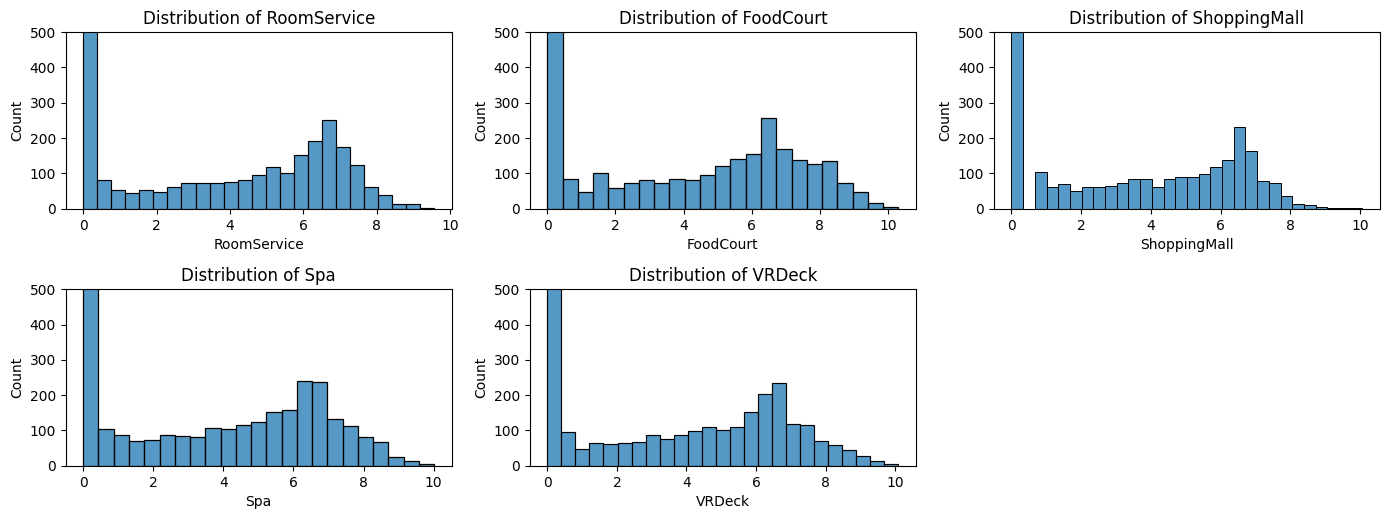

In [334]:
plt.figure(figsize=(14, 10))
for i, feature in enumerate(services):
    plt.subplot(4, 3, i + 1)
    sns.histplot(X_train_imputed[feature])
    plt.ylim([0, 500])
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

In [335]:
X_val_imputed.dtypes

HomePlanet          object
CryoSleep            int32
Destination         object
VIP                  int32
Deck                object
Side                object
IsAlone              int32
ExpenseCategory      int64
Age                float64
RoomService        float64
FoodCourt          float64
ShoppingMall       float64
Spa                float64
VRDeck             float64
TotalExpenses      float64
IsSpending           int32
CabinOrdinal       float64
GroupSize            int64
dtype: object

We will now preprocess data standardizing numerical features and encoding categorical features.

In [336]:
numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
)

transformer = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numeric_columns),
        ("cat", categorical_transformer, categorical_columns),
    ],
    remainder="passthrough",
)

X_train_transformed = transformer.fit_transform(X_train_imputed)
X_val_transformed = transformer.transform(X_val_imputed)
X_test_transformed = transformer.transform(X_test_imputed)

We forse target variable to be numeric

In [337]:
y_train_transformed = y_train.astype(int)
y_val_transformed = y_val.astype(int)

Since we have lost features name after transformation we will add them back.

In [338]:
ohe_feature_names = transformer.named_transformers_["cat"][
    "onehot"
].get_feature_names_out(categorical_columns)

feature_names = numeric_columns + list(ohe_feature_names) + boolean_columns

X_train_transformed = pd.DataFrame(X_train_transformed, columns=feature_names)
X_val_transformed = pd.DataFrame(X_val_transformed, columns=feature_names)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)

pd.set_option("display.max_columns", None)
X_train_transformed.head()

Age  RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  \
0 -0.055446     1.735254   0.407270     -0.617812 -0.669833 -0.641683   
1  0.499355     0.339493   1.818081     -0.346541  1.933914  2.106988   
2  1.262206    -0.634734  -0.654822     -0.617812 -0.669833 -0.641683   
3  0.430005     1.785224   0.921623      0.083413  0.885386 -0.641683   
4  1.817007    -0.634734  -0.654822     -0.617812  1.560875  1.829457   

   TotalExpenses  GroupSize  CabinOrdinal  ExpenseCategory  HomePlanet_Earth  \
0       0.591765   3.136379     -0.171937        -0.011517               1.0   
1       1.143237  -0.019396     -0.171937         0.935488               0.0   
2      -1.153655  -0.650551     -0.171937        -0.958521               0.0   
3       0.682014  -0.650551      0.629164        -0.011517               1.0   
4       0.808374   3.767534      0.629164         0.935488               1.0   

   HomePlanet_Europa  HomePlanet_Mars  Destination_55_Cancri_e  \
0                0.0              0.0                      1.0   
1                1.0              0.0                      1.0   
2                0.0              1.0                      0.0   
3                0.0              0.0                      0.0   
4                0.0              0.0                      0.0   

   Destination_PSO_J318.5-22  Destination_TRAPPIST-1e  Deck_A  Deck_B  Deck_C  \
0                        0.0                      0.0     0.0     0.0     0.0   
1                        0.0                      0.0     0.0     0.0     0.0   
2                        0.0                      1.0     0.0     0.0     0.0   
3                        0.0                      1.0     0.0     0.0     0.0   
4                        0.0                      1.0     0.0     0.0     0.0   

   Deck_D  Deck_E  Deck_F  Deck_G  Deck_T  Side_P  Side_S  CryoSleep  VIP  \
0     0.0     0.0     1.0     0.0     0.0     1.0     0.0        0.0  0.0   
1     0.0     1.0     0.0     0.0     0.0     0.0     1.0        0.0  0.0   
2     0.0     1.0     0.0     0.0     0.0     1.0     0.0        1.0  0.0   
3     0.0     0.0     0.0     1.0     0.0     0.0     1.0        0.0  0.0   
4     0.0     0.0     1.0     0.0     0.0     0.0     1.0        0.0  0.0   

   IsAlone  IsSpending  
0      0.0         1.0  
1      0.0         1.0  
2      1.0         0.0  
3      1.0         1.0  
4      0.0         1.0

Let's now display correlation between new features.

<Figure size 1000x800 with 0 Axes>

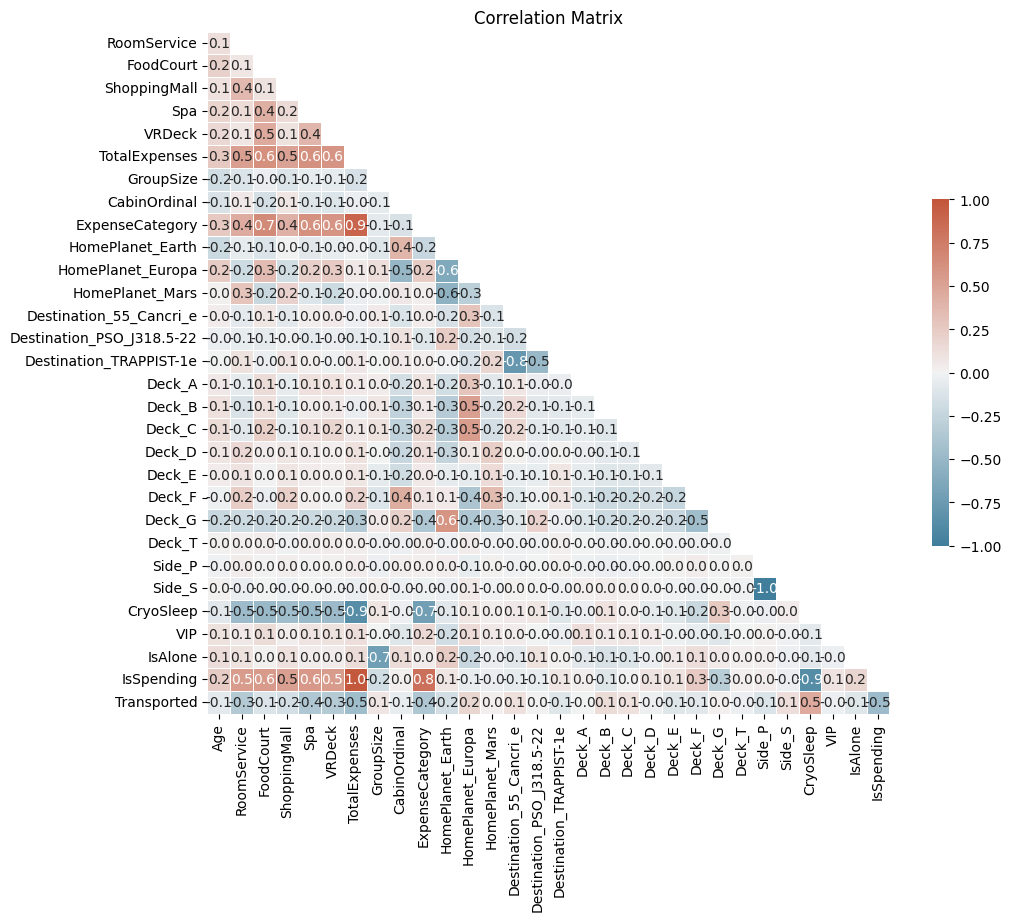

In [339]:
y_train_transformed = y_train_transformed.reset_index(drop=True)

only_numbers = X_train_transformed.copy()
only_numbers["Transported"] = y_train_transformed

only_numbers.head()

corr_matrix = only_numbers.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

corr_matrix_slice = corr_matrix.iloc[1:, :-1]
mask_slice = mask[1:, :-1]

plt.figure(figsize=(10, 8))
f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr_matrix_slice,
    annot=True,
    fmt=".1f",
    mask=mask_slice,
    cmap=cmap,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)
plt.title("Correlation Matrix")
plt.show()

At a first glance it seems that target variable is sensible to expenses and `CryoSleep` status.

## ***Model Selection***

We will run multiple models, with the help of RandomizedSearchCV, to find the best model for our data.

We will then select the best models and try to refin the hyperparameters using Optuna. Once we have the best models tuned, we will ensamble them for the max accuracy.



In [360]:
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state = SEED),
    "KNN" : KNeighborsClassifier(),
    "RandomForest" : RandomForestClassifier(random_state = SEED),
    "XGBoost" : XGBClassifier(objective='binary:logistic', random_state=SEED, eval_metric='logloss', use_label_encoder=False),
    "LGBM": LGBMClassifier(random_state=SEED, verbose=-1),
    "CatBoost": CatBoostClassifier(random_state=SEED, verbose=0)
}

grid = {
    "LogisticRegression": {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet', 'none'], 
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
        'max_iter': [100, 200, 300, 400, 500], 
        'class_weight': [None, 'balanced'], 
        'multi_class': ['auto', 'ovr', 'multinomial'],
    },
    "KNN": {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'], 
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
        'leaf_size': [20, 30, 40, 50], 
        'p': [1, 2], 
    },
    "RandomForest": {
        'n_estimators': randint(50, 300),
        'max_depth': randint(3, 15),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['auto', 'sqrt', 'log2'],
        'bootstrap': [True, False]
    },
    "XGBoost": {
        'n_estimators': randint(50, 300),
        'max_depth': randint(3, 15),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'gamma': uniform(0, 5),
        'reg_alpha': uniform(0, 5),
        'reg_lambda': uniform(0, 5)
    },
    "LGBM": {
        'n_estimators': randint(50, 201), 
        'max_depth': randint(-1, 13),
        'learning_rate': uniform(0.01, 0.14),
        'num_leaves': randint(31, 128),
        'min_data_in_leaf': randint(20, 101), 
        'feature_fraction': uniform(0.6, 0.4), 
        'bagging_fraction': uniform(0.6, 0.4),
        'bagging_freq': randint(1, 11)
    },
    "CatBoost": {
        'iterations': randint(50, 201), 
        'depth': randint(4, 10),
        'learning_rate': uniform(0.01, 0.2), 
        'l2_leaf_reg': uniform(1, 10), 
        'bagging_temperature': uniform(0, 1), 
        'border_count': randint(32, 255), 
    },
}

In [361]:
best_estimators = {}
clf_best_params = classifiers.copy()
confusion_matrices = {}
valid_scores = pd.DataFrame({
    'Classifier': classifiers.keys(),
    'Validation accuracy': np.zeros(len(classifiers)),
    'Training time': np.zeros(len(classifiers))
})

for idx, (key, classifier) in enumerate(classifiers.items()):
    start_time = time.time()

    clf = RandomizedSearchCV(estimator=classifier, scoring='accuracy',
                             param_distributions=grid[key], n_iter=100,
                             n_jobs=-1, verbose=0, random_state=SEED, cv=5)
    
    clf.fit(X_train_transformed, y_train_transformed)

    best_estimators[key] = clf.best_estimator_
    clf_best_params[key] = clf.best_params_

    valid_scores.loc[idx, 'Validation accuracy'] = clf.score(X_val_transformed, y_val_transformed)

    y_pred = clf.best_estimator_.predict(X_val_transformed)
    confusion_matrices[key] = confusion_matrix(y_val_transformed, y_pred)

    training_time = np.round((time.time() - start_time) / 60, 2)
    valid_scores.loc[idx, 'Training time'] = training_time

    print(f'Model: {key}')
    print(f'Training time (mins): {training_time}\n')


Model: LogisticRegression
Training time (mins): 0.25

Model: KNN
Training time (mins): 1.1

Model: RandomForest
Training time (mins): 1.49

Model: XGBoost
Training time (mins): 0.61

Model: LGBM
Training time (mins): 1.09

Model: CatBoost
Training time (mins): 2.91



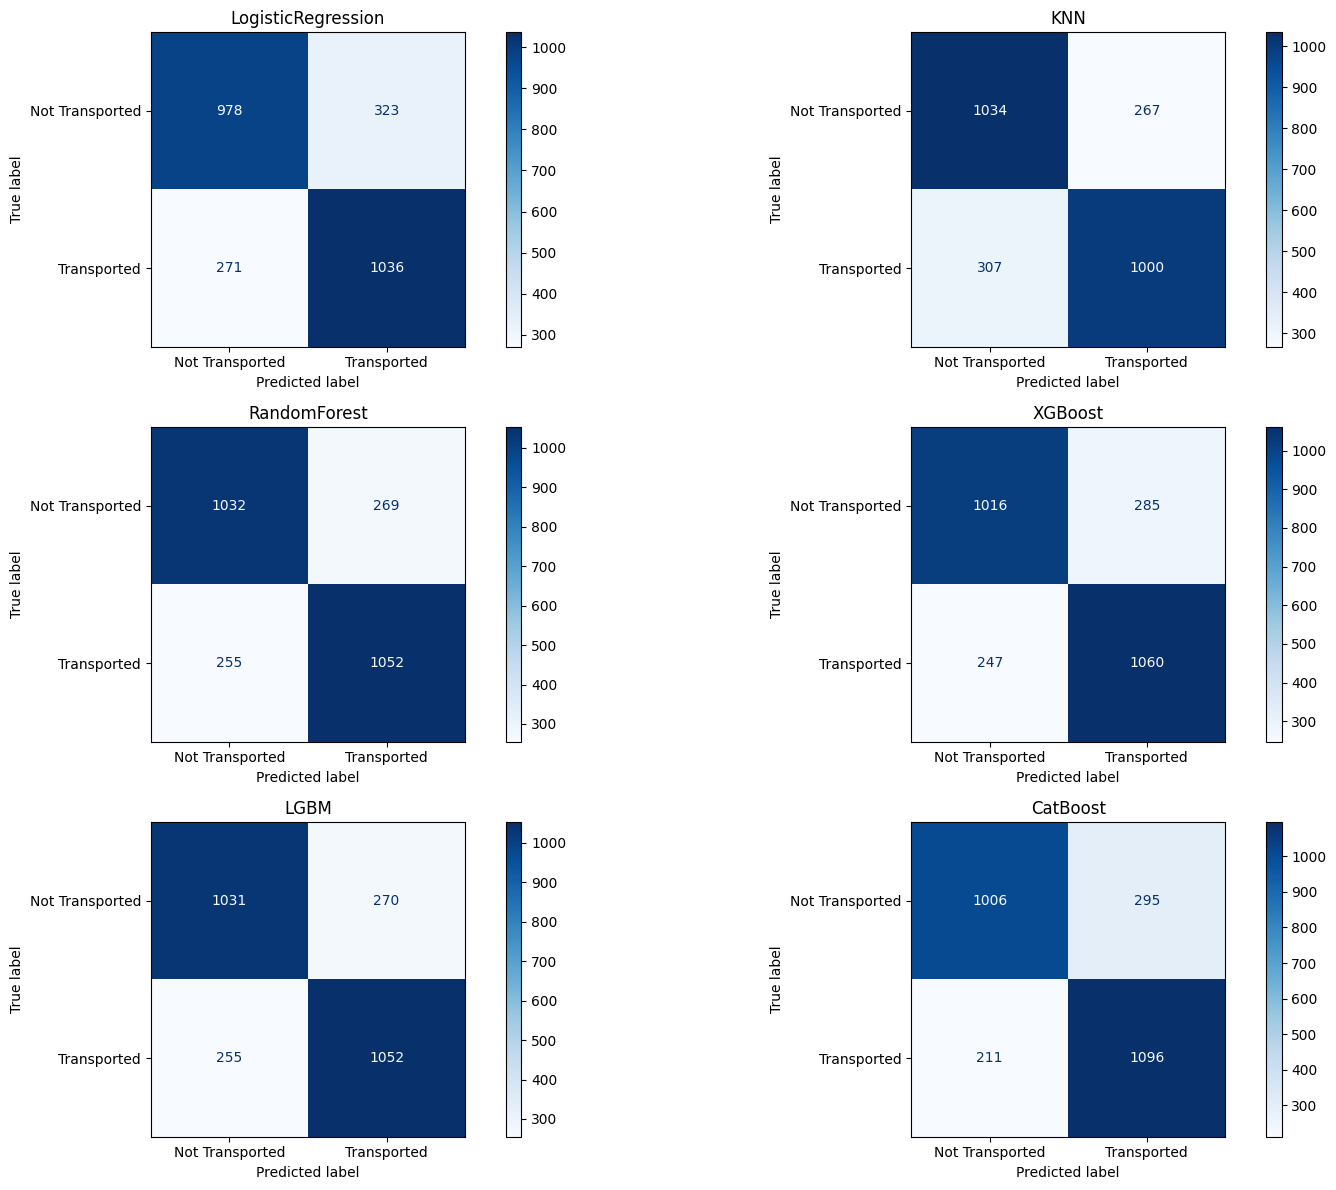

In [363]:
n_classifiers = len(confusion_matrices)

fig, axes = plt.subplots(nrows=(n_classifiers + 1) // 2, ncols=2, figsize=(16, 12))
axes = axes.flatten() 

for ax, (model_name, cm) in zip(axes, confusion_matrices.items()):
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["Not Transported", "Transported"]
    )
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    ax.set_title(model_name)

for i in range(n_classifiers, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

From confusion matrices it seems that the best models to combine for improving accuracy are CatBoost and LGBM. Let's evaluate all metrics.

In [362]:
metrics = {}

for model_name, cm in confusion_matrices.items():
    TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    metrics[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
    }

metrics_df = pd.DataFrame(metrics).T

display(metrics_df)

Accuracy  Precision    Recall
LogisticRegression  0.772239   0.762325  0.792655
KNN                 0.779908   0.789266  0.765111
RandomForest        0.799080   0.796366  0.804897
XGBoost             0.796012   0.788104  0.811018
LGBM                0.798696   0.795764  0.804897
CatBoost            0.805982   0.787922  0.838562

In [ ]:
best_classifiers = {
    "LGBM": LGBMClassifier(**clf_best_params["LGBM"], random_state=SEED),
    "CatBoost": CatBoostClassifier(
        **clf_best_params["CatBoost"], verbose=False, random_state=SEED
    ),
}

We will further try to improve the accuracy of the two best models with Optuna since AutoSKLeearn is not working on Windows.

In [375]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

best_classifiers = {
    "LGBM": LGBMClassifier(random_state=0, verbose=-1),
    "CatBoost": CatBoostClassifier(random_state=0, verbose=0),
}

def get_param_spaces(classifier_name):
    if classifier_name == "LGBM":
        return {
            "n_estimators": optuna.distributions.IntDistribution(50, 500),
            "learning_rate": optuna.distributions.FloatDistribution(0.001, 0.1),
            "num_leaves": optuna.distributions.IntDistribution(20, 150),
            "max_depth": optuna.distributions.IntDistribution(3, 10),
        }
    elif classifier_name == "CatBoost":
        return {
            "iterations": optuna.distributions.IntDistribution(100, 500),
            "learning_rate": optuna.distributions.FloatDistribution(0.001, 0.1),
            "depth": optuna.distributions.IntDistribution(3, 10),
        }

def objective(trial, classifier_name):
    params = get_param_spaces(classifier_name)
    if classifier_name == "LGBM":
        model = LGBMClassifier(
            n_estimators=trial.suggest_int(
                "n_estimators", params["n_estimators"].low, params["n_estimators"].high
            ),
            learning_rate=trial.suggest_float(
                "learning_rate",
                params["learning_rate"].low,
                params["learning_rate"].high,
            ),
            num_leaves=trial.suggest_int(
                "num_leaves", params["num_leaves"].low, params["num_leaves"].high
            ),
            max_depth=trial.suggest_int(
                "max_depth", params["max_depth"].low, params["max_depth"].high
            ),
        )
    elif classifier_name == "CatBoost":
        model = CatBoostClassifier(
            iterations=trial.suggest_int(
                "iterations", params["iterations"].low, params["iterations"].high
            ),
            learning_rate=trial.suggest_float(
                "learning_rate",
                params["learning_rate"].low,
                params["learning_rate"].high,
            ),
            depth=trial.suggest_int("depth", params["depth"].low, params["depth"].high),
        )


    model.fit(X_train_transformed, y_train_transformed)
    preds = model.predict(X_val_transformed)
    accuracy = accuracy_score(y_val_transformed, preds)
    return accuracy

def run_optuna_study(classifier_name, n_trials=50):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, classifier_name), n_trials=n_trials)
    return study.best_trial.params

best_params = {}
for key, classifier in best_classifiers.items():
    debug(f"Running Optuna for {key}...")
    best_params[key] = run_optuna_study(key)

Running Optuna for LGBM...
Running Optuna for CatBoost...
0:	learn: 0.6652732	total: 3.19ms	remaining: 970ms
1:	learn: 0.6417069	total: 5.82ms	remaining: 882ms
2:	learn: 0.6220153	total: 8.98ms	remaining: 904ms
3:	learn: 0.6051419	total: 12.3ms	remaining: 924ms
4:	learn: 0.5916033	total: 15.7ms	remaining: 943ms
5:	learn: 0.5788879	total: 18.6ms	remaining: 927ms
6:	learn: 0.5694290	total: 21.7ms	remaining: 925ms
7:	learn: 0.5599431	total: 24.8ms	remaining: 920ms
8:	learn: 0.5498229	total: 28.2ms	remaining: 927ms
9:	learn: 0.5413258	total: 31.3ms	remaining: 924ms
10:	learn: 0.5346072	total: 34.5ms	remaining: 923ms
11:	learn: 0.5275361	total: 37.5ms	remaining: 917ms
12:	learn: 0.5221804	total: 40.8ms	remaining: 916ms
13:	learn: 0.5166357	total: 44.6ms	remaining: 928ms
14:	learn: 0.5108185	total: 47.7ms	remaining: 923ms
15:	learn: 0.5068947	total: 50.7ms	remaining: 916ms
16:	learn: 0.5017838	total: 53.8ms	remaining: 912ms
17:	learn: 0.4982758	total: 57.2ms	remaining: 912ms
18:	learn: 0.495

After tuning we train final models with the best params to determine the best estimators and calculate the new accuracy.

In [376]:
best_estimators = {}
for key, classifier in best_classifiers.items():
    if key == "LGBM":
        clf = LGBMClassifier(**best_params[key], random_state=SEED)
    elif key == "CatBoost":
        clf = CatBoostClassifier(**best_params[key], random_state=SEED, verbose=False)

    # Fit the final model
    clf.fit(X_train_transformed, y_train_transformed)
    best_estimators[key] = clf

    # Evaluate the model on validation set
    y_pred = clf.predict(X_val_transformed)
    accuracy = accuracy_score(y_val_transformed, y_pred)
    print(f"{key} Validation Accuracy: {accuracy:.4f}")

LGBM Validation Accuracy: 0.8029
CatBoost Validation Accuracy: 0.8079


We have improved both models score.

Let's run SHAP on both models to see which features have contributed the most to the predictions.

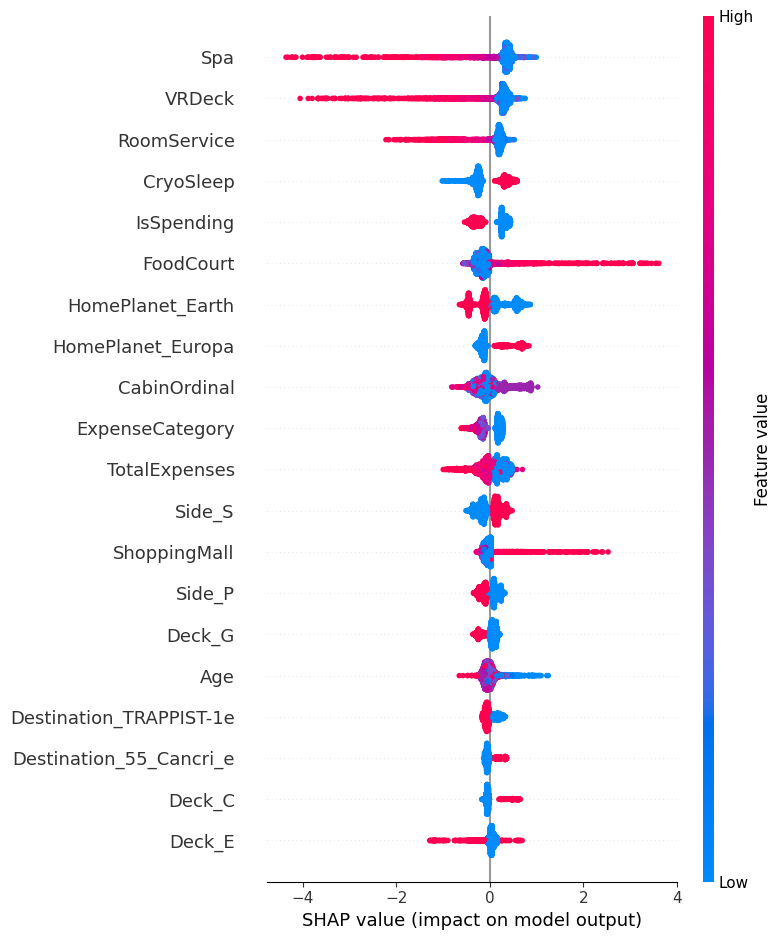

In [347]:
best_catboost = best_estimators["CatBoost"]
catboost_explainer = shap.TreeExplainer(best_catboost)
catboost_shap_values = catboost_explainer.shap_values(X_val_transformed)
shap.summary_plot(catboost_shap_values, X_val_transformed, feature_names=feature_names)

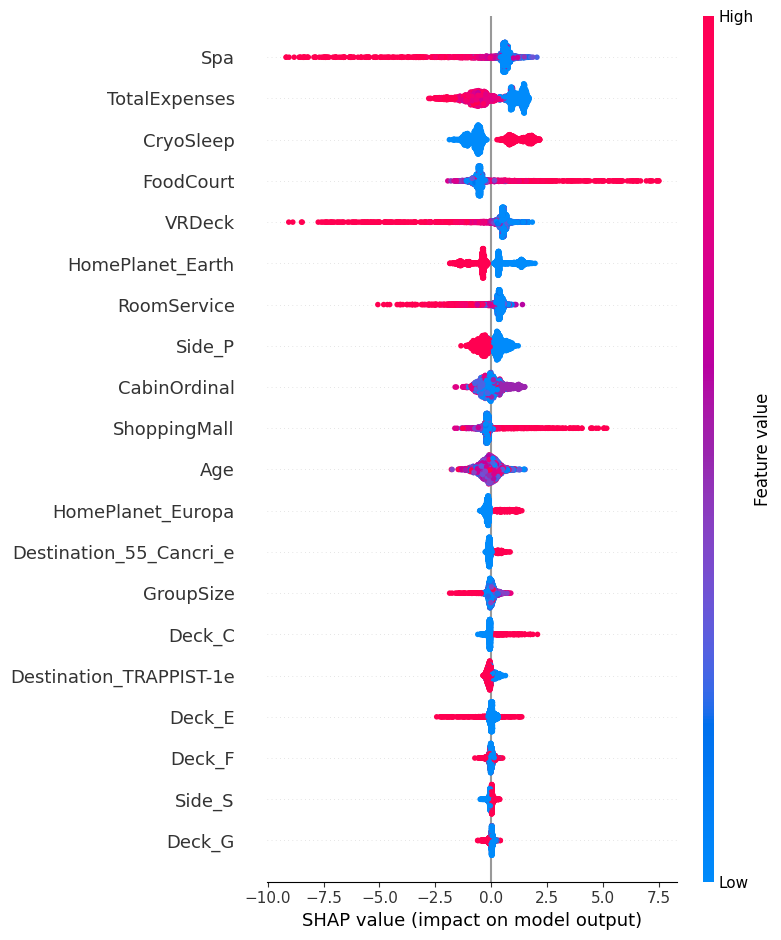

In [351]:
explainer2 = shap.TreeExplainer(best_estimators["LGBM"])

shap_values2 = explainer2.shap_values(X_val_transformed)
shap.summary_plot(shap_values2, X_val_transformed, feature_names=feature_names)

`Spa`, `VRDeck`, and `RoomService` are the most impactful features, in negative, for `Transported` prediction, on the opposite, the other 2 expenses, have the largest positive impact. They are split the same way `VIP` status was related to them, it is surprising that it is not even in the least of features. 

### ***Ensembling***

We select the 2 models with best precision and recall to ensemble a better model. We will use a soft vote ensambler with cross validation to combine the predictions of the two models.

Then we will export the model to a pickle file and use it in the web app.

In [377]:
import joblib

FOLDS = 10

X_merged = pd.concat([X_train_imputed, X_val_imputed], axis=0, ignore_index=True)
y_merged = pd.concat(
    [y_train_transformed, y_val_transformed], axis=0, ignore_index=True
)

preds = np.zeros(len(X_test_transformed))
for key, classifier in best_estimators.items():
    start = time.time()

    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

    score = 0
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_merged, y_merged)):

        X_train_split, X_val_split = X_merged.iloc[train_idx], X_merged.iloc[val_idx]
        y_train_split, y_val_split = y_merged.iloc[train_idx], y_merged.iloc[val_idx]

        X_train_trans = transformer.fit_transform(X_train_split)
        X_val_trans = transformer.transform(X_val_split)
        X_test_trans = transformer.transform(X_test_imputed)

        clf = classifier
        clf.fit(X_train_trans, y_train_split)

        preds += clf.predict_proba(X_test_trans)[:, 1]
        score += clf.score(X_val_trans, y_val_split)

    score = score / FOLDS

    stop = time.time()

    print("Model:", key)
    print("Average validation accuracy:", np.round(100 * score, 2))
    print("Training time (mins):", np.round((stop - start) / 60, 2))
    print("")

preds = preds / (FOLDS * len(best_estimators))

# Save the individual models
for key, model in best_estimators.items():
    joblib.dump(model, f'app/{key}_model.pkl')

# Save the transformer
joblib.dump(transformer, 'app/transformer.pkl')

# Save additional components if necessary
ensemble_components = {
    'best_estimators': list(best_estimators.keys()),
    'FOLDS': FOLDS,
    'SEED': SEED,
    'X_test_transformed': X_test_transformed,
    'X_test_imputed': X_test_imputed
}
joblib.dump(ensemble_components, 'app/ensemble_components.pkl')

print("Models and components saved.")

Model: LGBM
Average validation accuracy: 81.35
Training time (mins): 0.09

Model: CatBoost
Average validation accuracy: 81.76
Training time (mins): 0.14

Models and components saved.


Let's now combine the dataframe for submission and compare the distribution of passengers transported for train dataset and test dataset.

In [371]:
predicted = pd.read_csv("dataset/sample_submission.csv")

predicted["Transported"] = np.round(preds).astype(int)

predicted = predicted.replace({0: False, 1: True})

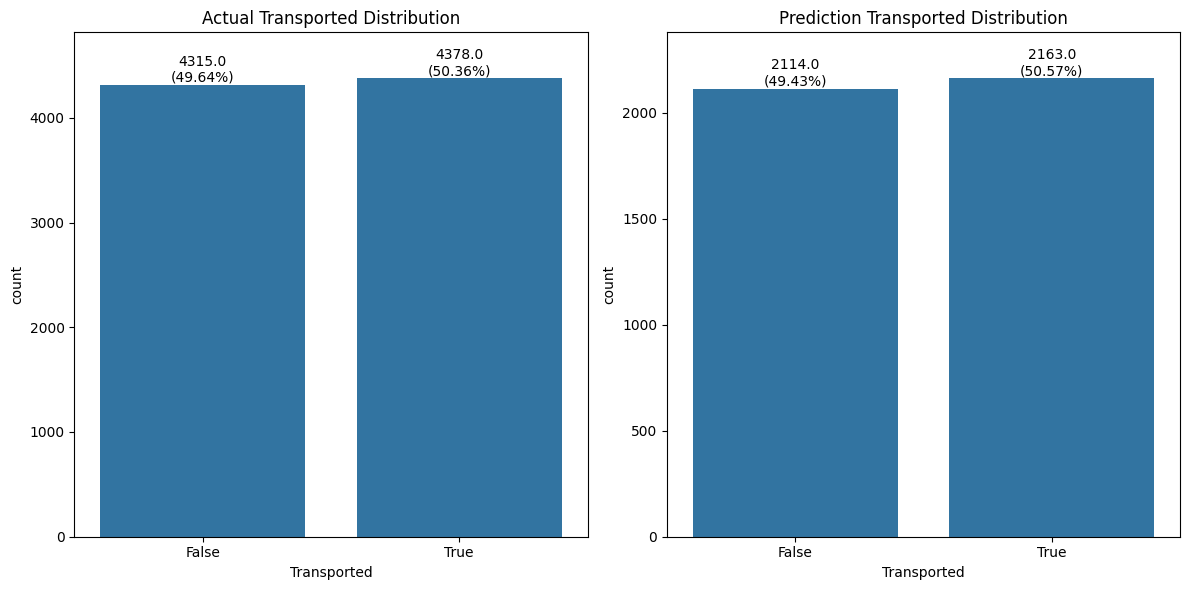

In [372]:
total_actual = len(train_data)  
total_pred = len(predicted)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax1 = sns.countplot(x='Transported', data=train_data, ax=axes[0])
ax1.set_title("Actual Transported Distribution")

for p in ax1.patches:
    count = p.get_height()
    percentage = 100 * count / total_actual
    ax1.annotate(f'{count}\n({percentage:.2f}%)', 
                 (p.get_x() + p.get_width() / 2., count), 
                 ha='center', va='bottom')

ax1.set_ylim(0, max([p.get_height() for p in ax1.patches]) * 1.1)

ax2 = sns.countplot(x='Transported', data=predicted, ax=axes[1])
ax2.set_title("Prediction Transported Distribution")

for p in ax2.patches:
    count = p.get_height()
    percentage = 100 * count / total_pred
    ax2.annotate(f'{count}\n({percentage:.2f}%)', 
                 (p.get_x() + p.get_width() / 2., count), 
                 ha='center', va='bottom')

ax2.set_ylim(0, max([p.get_height() for p in ax2.patches]) * 1.1)

plt.tight_layout()
plt.show()


The rate of Transported passengers is very similar, if test is a random subset of the whole dataset we can be confident that the accuracy is similar to the one obtained on the train dataset.

In [357]:
predicted.to_csv("dataset/submission.csv", index=False)

## ***Conclusions***

It looks like for this specific case, even though missing values represented a small portion of the dataset, their imputation can have a very heavy impact on the model's performance.

In this specific case a lot of efforts have been made to improve the model's performance, but it seems that the imputation strategy was not qualitative enough to significantly improve the model's performance.

### ***Key Insights***

- **Feature Importance**:
  - All expenses features were found to be significant predictors of passenger survival in both positive and negative way.
  - Some features that were missing and could be inferred might have had a significant impact on the model's predictions.

- **Model Performance**:
  - The best-performing model achieved an accuracy of over 80%, combining the precision and recall results of different models.
  - The SHAP analysis provided valuable insights into how different features influence the model's predictions.

### ***Recommendations***

- **Model Improvement**:
  - Explore advanced machine learning techniques, different ensempling or AutoML could further improve the model's performance.
  - Perform more extensive hyperparameter tuning could have an additional impact on the model's performance.

- **Feature Engineering**:
  - Investigate other feature engineering techniques to create more informative features, gender feature and some more splitting could have added important contribution to the prediction.
